<a href="https://colab.research.google.com/github/ASi-F/DS203_Project/blob/main/ARWU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA for *Academic Ranking of World Universities* (ARWU)

In [1]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

os.chdir("/content/drive/MyDrive/Project")

In [5]:
localdirectory = "./Datasets/Shanghai/shanghai-world-university-ranking.csv" # for local
df = pd.read_csv(localdirectory,sep = ';')

# Overall
## Notation
Indicators and weights for ARWU : [link](https://www.shanghairanking.com/methodology/arwu/2021#:~:text=3.%20Indicators%20and,to%20other%20indicators.)

- Alumni : Alumni of an institution winning Nobel Prizes and Fields Medals
- Award  : Staff of an institution winning Nobel Prizes and Fields Medals
- HiCi   : Highly Cited Researchers
- N&S    : Papers published in Nature and Science*
- PUB    : Papers indexed in Science Citation Index-Expanded and Social Science Citation Index
- PCP    : Per capita academic performance of an institution

*For institutions specialized in humanities and social sciences such as London School of Economics, N&S is not considered, and the weight of N&S is relocated to other indicators.

For more information visit: https://www.shanghairanking.com/methodology/arwu/2021


In [6]:
def preprocess(df):
  df['World rank'] = df['World rank integer']
  df = df.drop(columns = ['Geo Shape', 'ISO2 CODE', 'ISO3 CODE', 'World rank integer','Geo Point 2D'])
  df['Total score'] = 0.1*df['Alumni']+0.2*df['Award']+0.2*df['Hi Ci']+0.2*df['N&S']+0.1*df['PCP']+0.2*df['PUB']
  df = df.dropna()
  df = df.set_index(pd.Index(list(range(len(df)))))
  df = df[['Year','University','Country','Alumni','Award','Hi Ci','N&S','PUB','PCP','Total score','World rank','National rank']]
  min_year = min(df['Year'])
  max_year = max(df['Year'])
  df_all_years = df
  df = {}
  for year in range(min_year,max_year+1):
    df[year] = df_all_years[df_all_years['Year'] == year]
    df[year] = df[year].sort_values(by = ['Total score'], ascending = False)
    df[year] = df[year].set_index(pd.Index(range(len(df[year]))))

    df[year]['World rank'] = list(range(1,len(df[year])+1))
    for i in range(1,len(df[year])):
      if df[year]['Total score'][i] == df[year]['Total score'][i-1]:
        df[year]['World rank'][i] = df[year]['World rank'][i-1]
    
  return df

In [7]:
df = preprocess(df)
min_year = min(df.keys())
max_year = max(df.keys())
print(min_year,max_year)

2005 2018


In [8]:
indexes = set(df[2018]['University'])

for j in df.keys():
    k = set(df[j]['University'])
    indexes = indexes.intersection(k)

a = list(indexes)
a.sort()
a.remove("Queen's University") #data for this university was very random and didn't make sense
print(a)
print("Total number of common universities",len(a))

['Aarhus University', 'Aristotle University of Thessaloniki', 'Autonomous University of Barcelona', 'Autonomous University of Madrid', 'Baylor College of Medicine', 'Ben-Gurion University of the Negev', 'Boston College', 'Boston University', 'Brandeis University', 'Brigham Young University', 'Brown University', 'California Institute of Technology', 'Cardiff University', 'Carnegie Mellon University', 'Case Western Reserve University', 'Catholic University of Louvain', 'Chalmers University of Technology', 'Charles University in Prague', 'City University of Hong Kong', 'City University of New York City College', 'Claude Bernard University Lyon 1', 'Colorado State University', 'Columbia University', 'Complutense University of Madrid', 'Cornell University', 'Dalhousie University', 'Dartmouth College', 'Delft University of Technology', 'Drexel University', 'Duke University', 'Ecole Normale Superieure - Paris', 'Ecole Polytechnique', 'Eindhoven University of Technology', 'Emory University', '

Names of universities that are common in the rankings across the years

In [9]:
data = pd.DataFrame()
for i in df.keys():
    curr = df[i][df[i]['University'].isin(indexes)].assign(year=i)
    data = pd.concat([data,curr], axis=0)

In [10]:
display(data)

Year  ...  year
0    2005  ...  2005
1    2005  ...  2005
2    2005  ...  2005
4    2005  ...  2005
5    2005  ...  2005
..    ...  ...   ...
467  2018  ...  2018
472  2018  ...  2018
474  2018  ...  2018
487  2018  ...  2018
497  2018  ...  2018

[4433 rows x 13 columns]

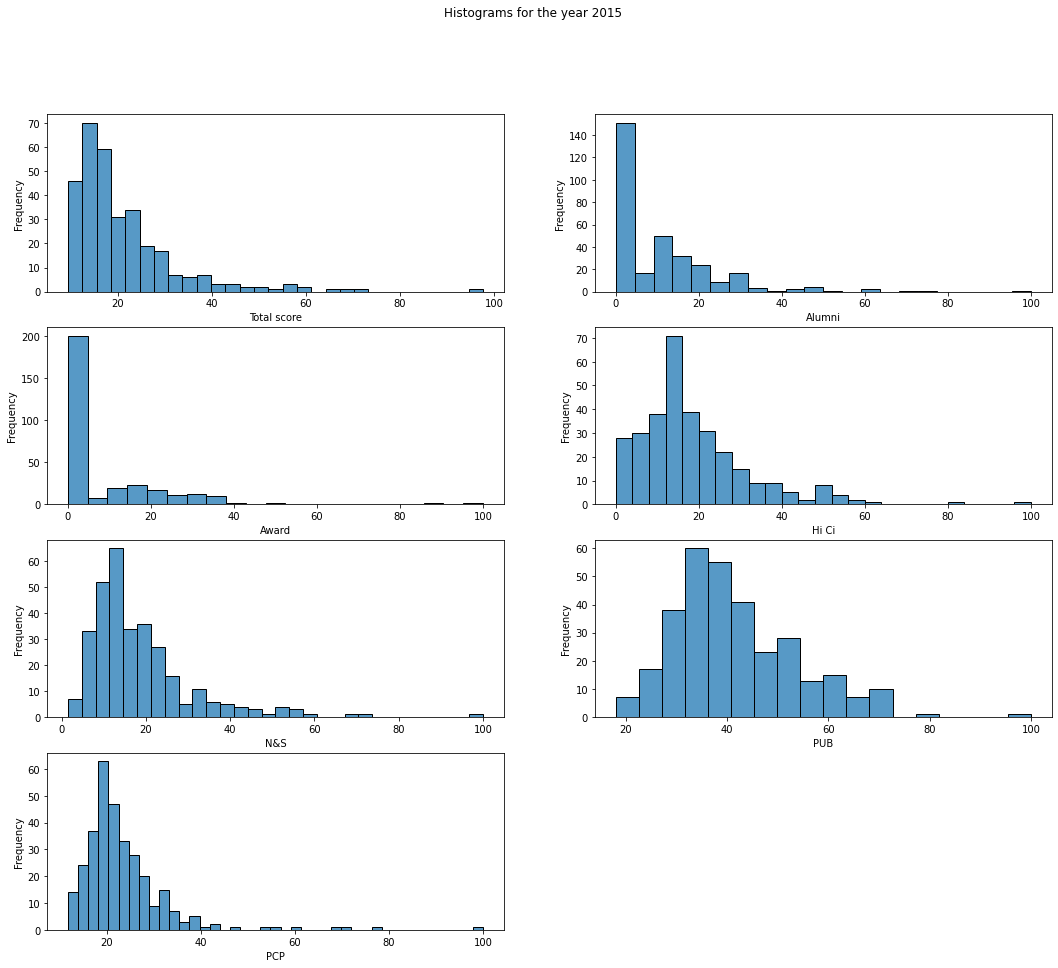

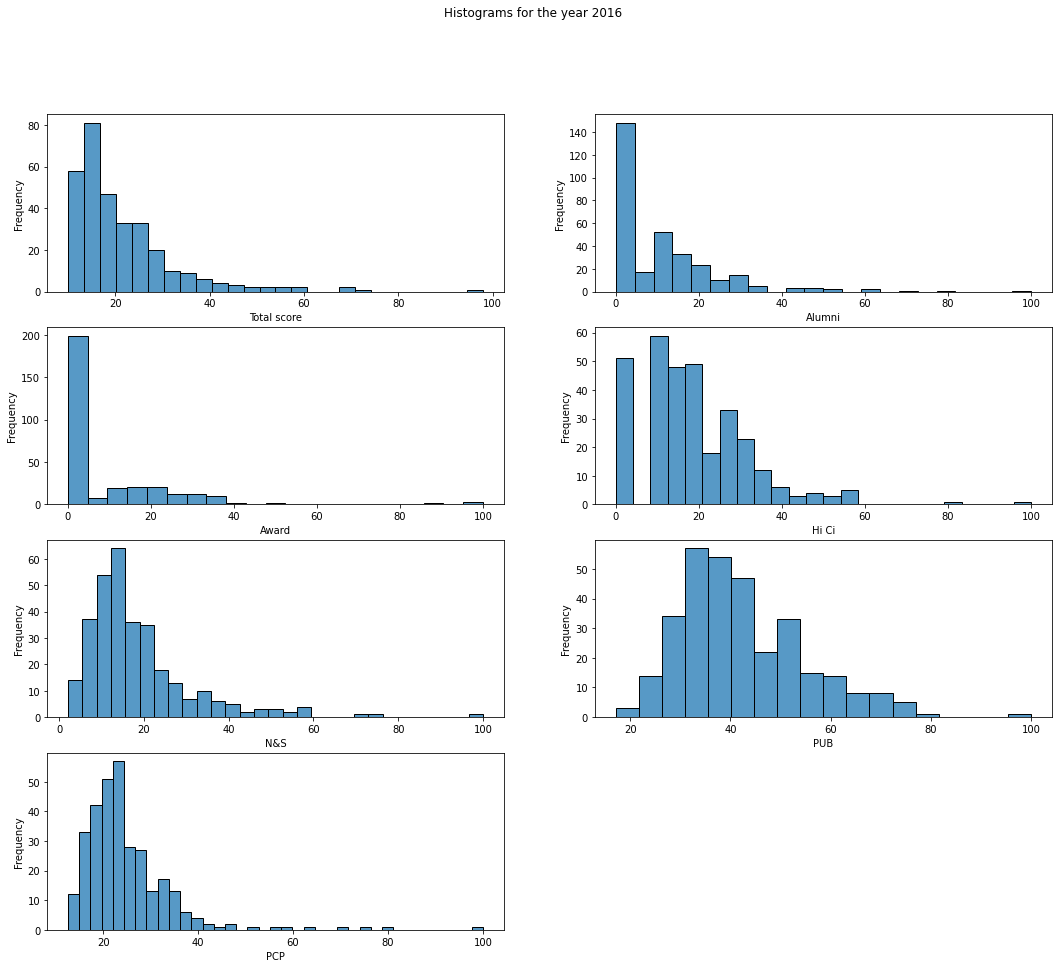

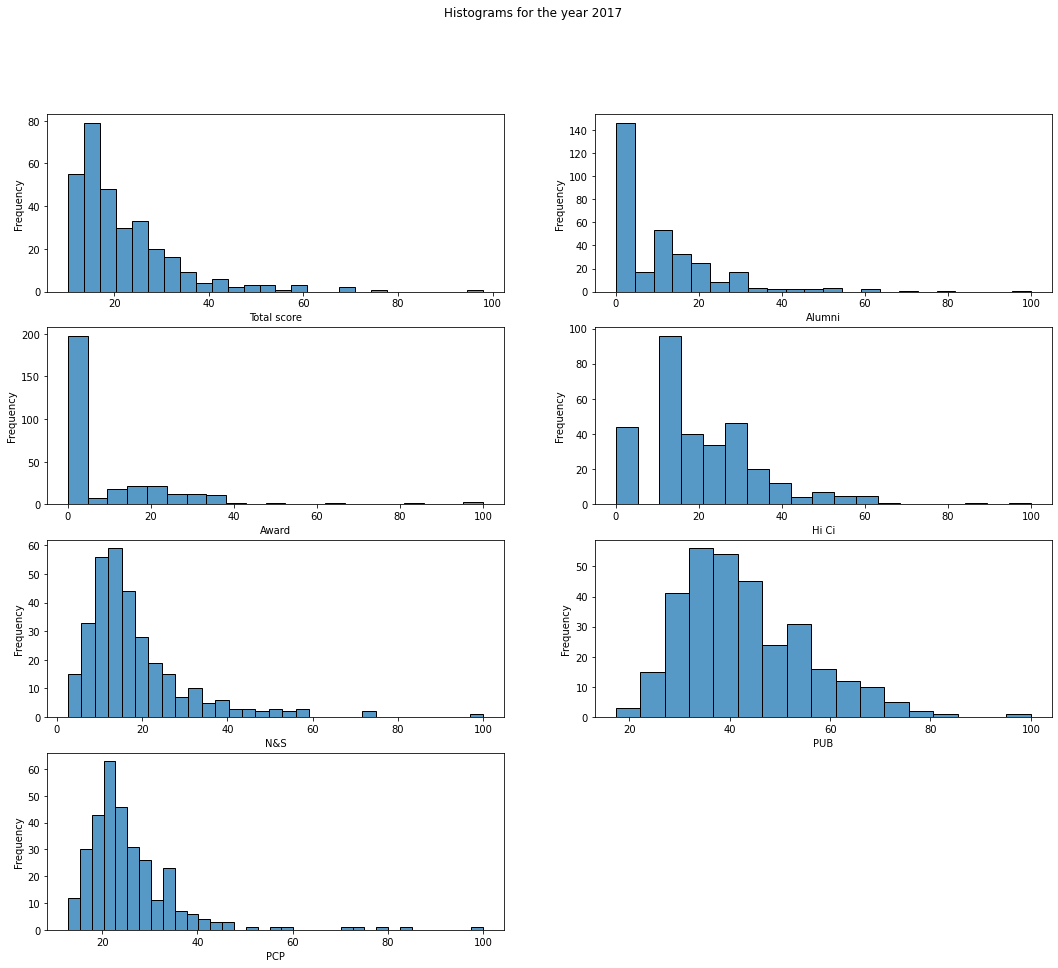

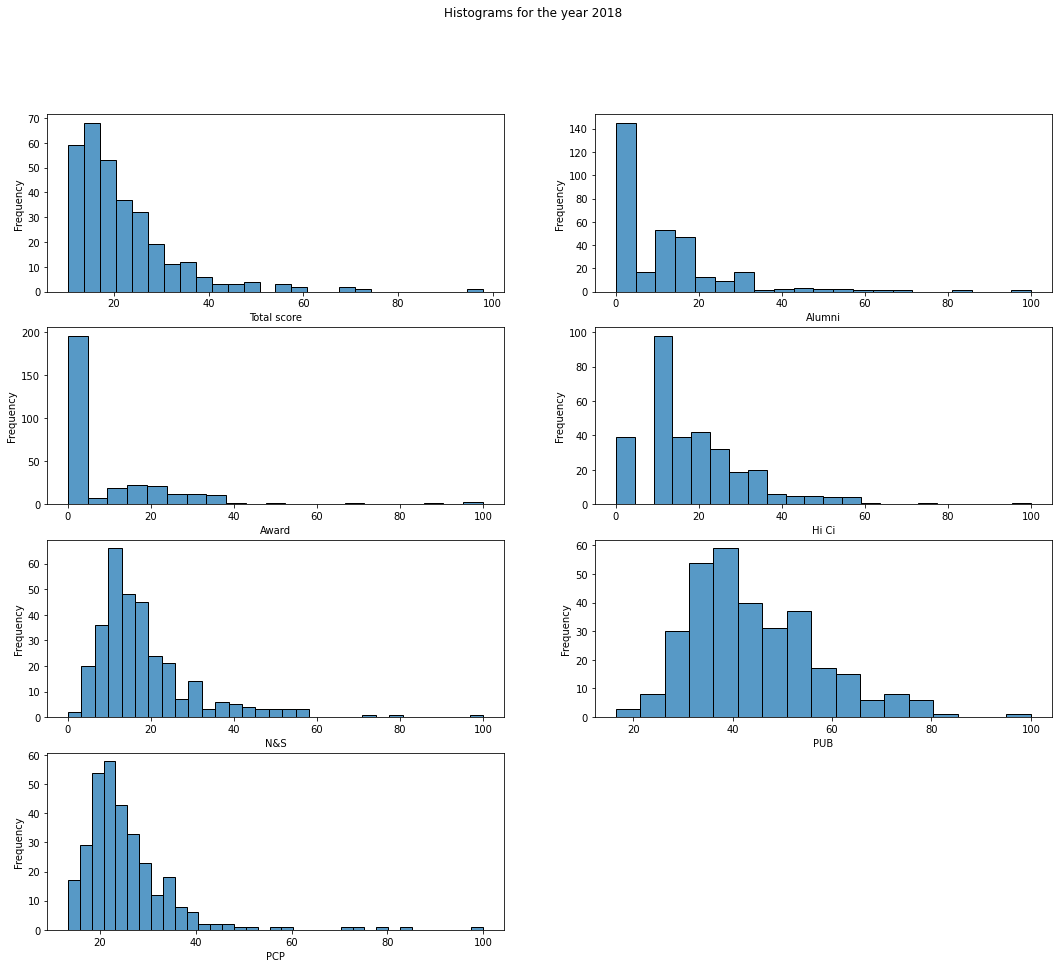

In [11]:
plt.rcParams['figure.figsize'] = [18,15]
for i,j in data.groupby('year'):
  if i in [2015,2016,2017,2018]:
    cols = ['Total score','Alumni','Award','Hi Ci','N&S','PUB','PCP']
    stat_data = j[cols]
    cols = ['Total score','Alumni','Award','Hi Ci','N&S','PUB','PCP']
    plt.figure()
    plt.suptitle(f"Histograms for the year {i}")
    for k in range(len(cols)):
      plt.subplot(4,2,k+1)
      sns.histplot(stat_data[cols[k]], bins='auto')
      plt.xlabel(f"{cols[k]}")
      plt.ylabel(f"Frequency")
    plt.show()

The histograms show that along the years there is not much variation in the nature of the distribution over the years

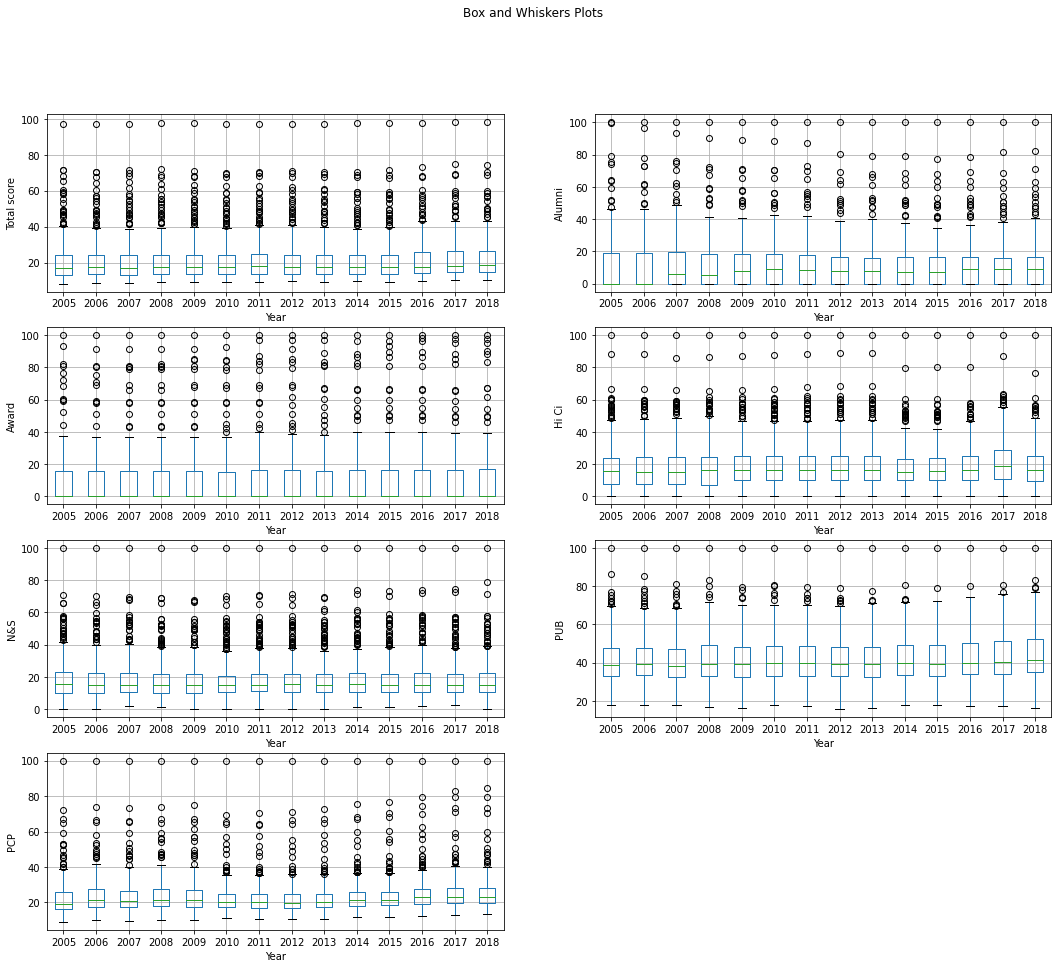

In [12]:
plt.rcParams['figure.figsize'] = [25,15]

cols = ['Total score','Alumni','Award','Hi Ci','N&S','PUB','PCP']
plt.rcParams['figure.figsize'] = [18,15]
plt.figure()
plt.suptitle("Box and Whiskers Plots")
for i in range(len(cols)):
    plt.subplot(4,2,i+1)
    plot_dict = {}
    for key,val in data.groupby("year"):
      plot_dict[key] = val[cols[i]]
    plot_df = pd.DataFrame(plot_dict)
    plot_df.boxplot()
    plt.xlabel("Year")
    plt.ylabel(cols[i])
plt.show()

- There are many outliers indicating some colleges outperform the others

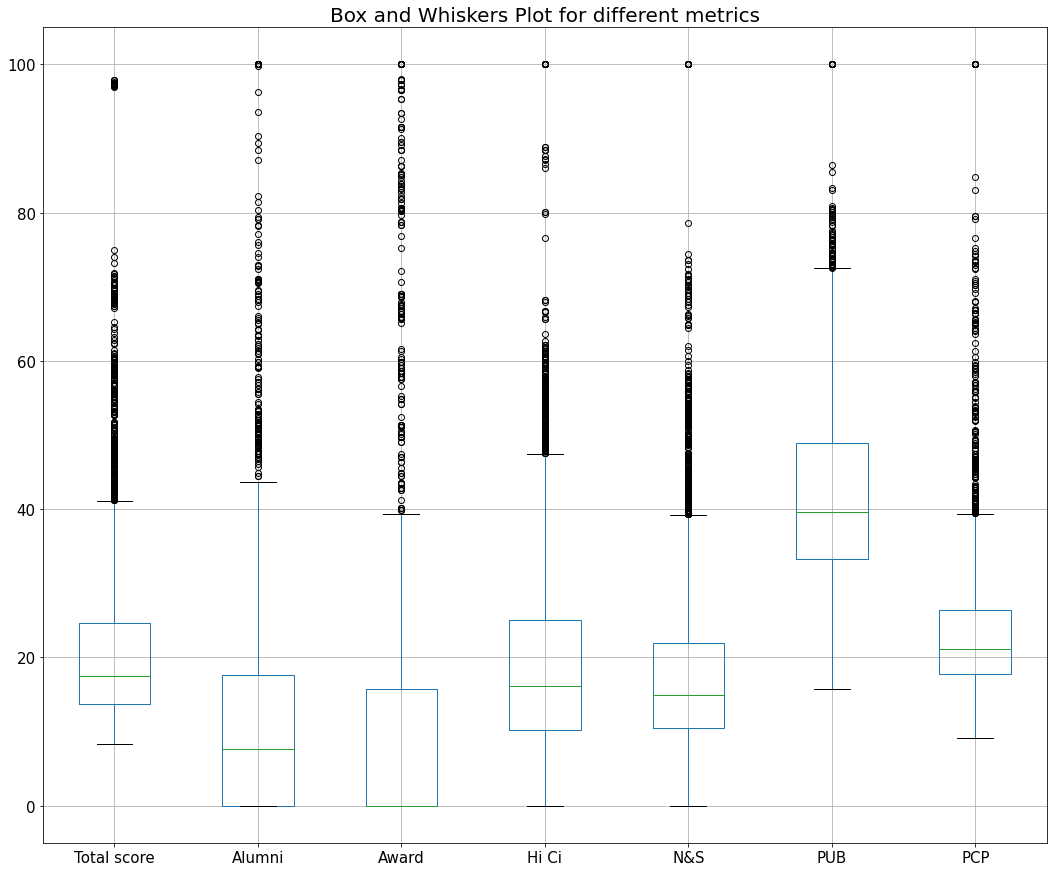

In [13]:
data.boxplot(column = cols, fontsize = 15)
plt.title('Box and Whiskers Plot for different metrics',fontdict={'fontsize':20})
pass

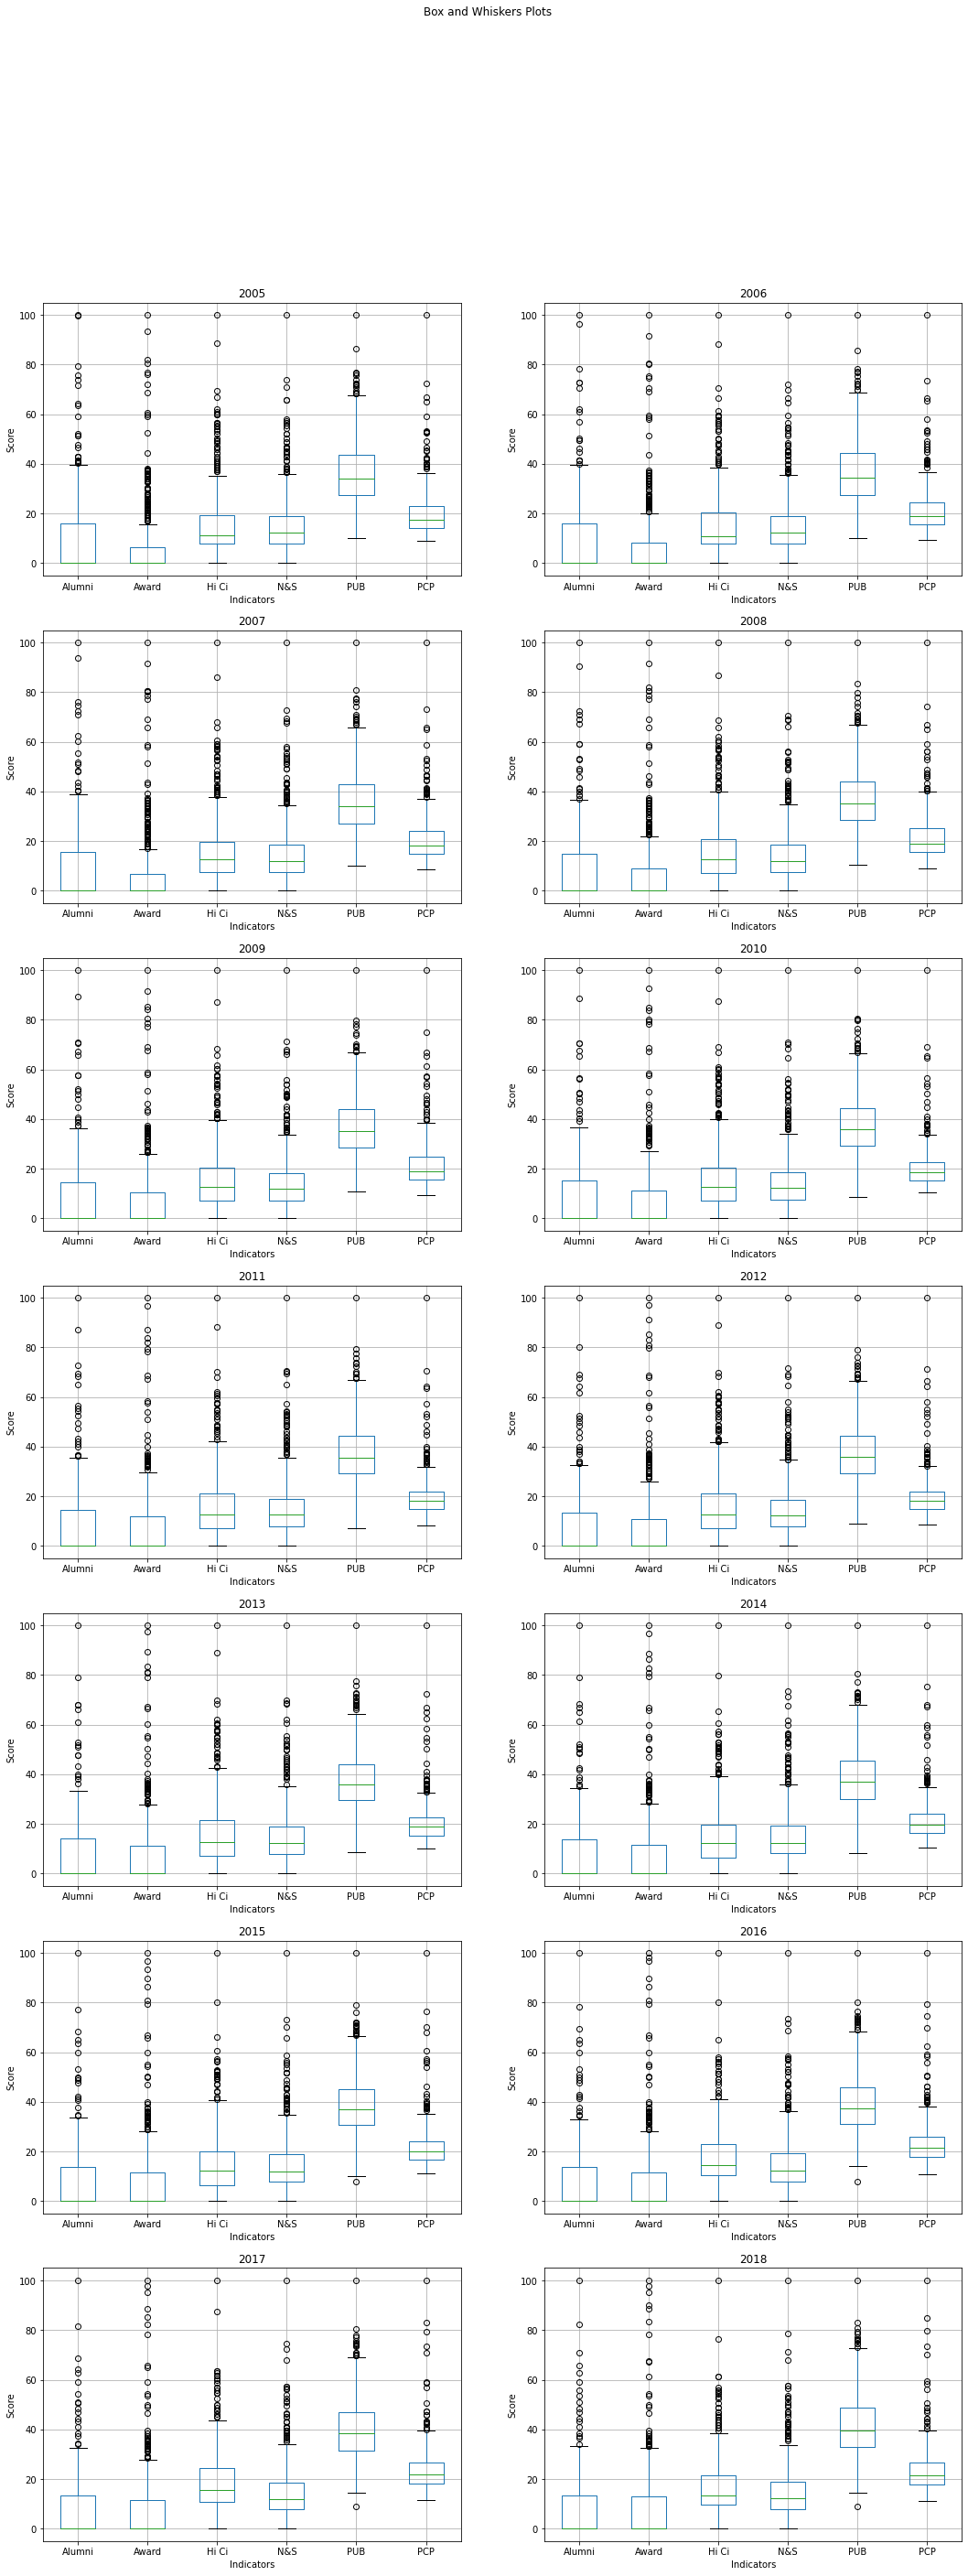

In [14]:
plt.rcParams['figure.figsize'] = [18,45]

cols = ['Alumni','Award','Hi Ci','N&S','PUB','PCP']
plt.figure()
plt.suptitle("Box and Whiskers Plots")
for i in range(min_year,max_year+1):
    plt.subplot(7,2,i+1-min_year)
    df[i][cols].boxplot(column = cols)
    plt.xlabel("Indicators")
    plt.ylabel("Score")
    plt.title(str(i))
plt.show()

- Each parameter almost has a similar distribution every year, which again vouches for the point we inferred from the histogram
- There are many outliers

In [15]:
plt.rcParams['figure.figsize'] = [12,8]

# Mean plots for batches of 10

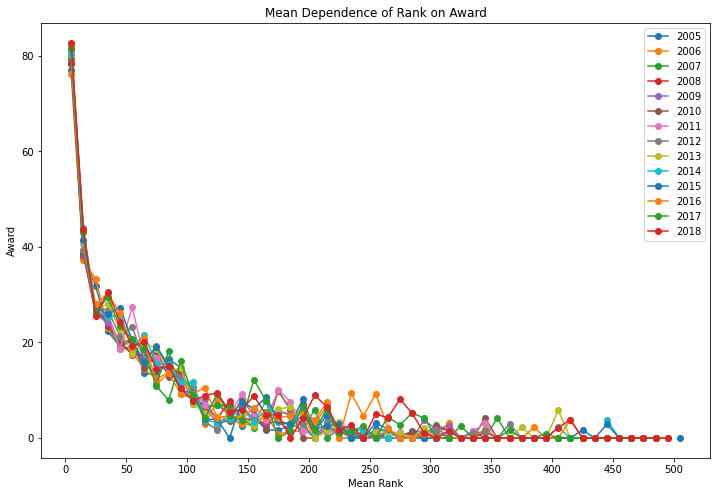

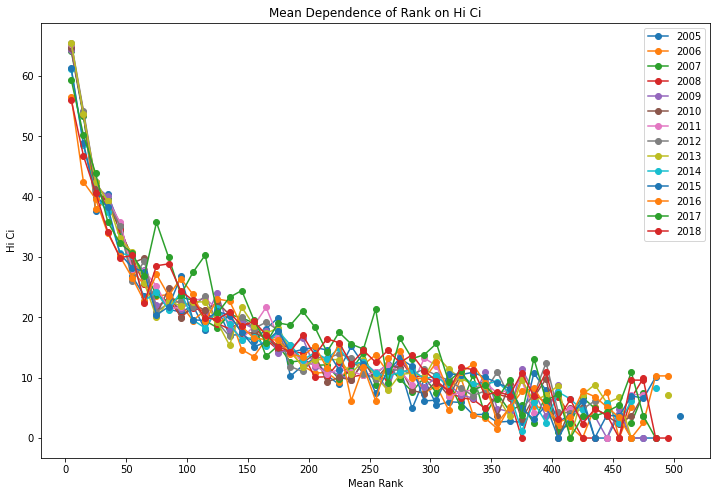

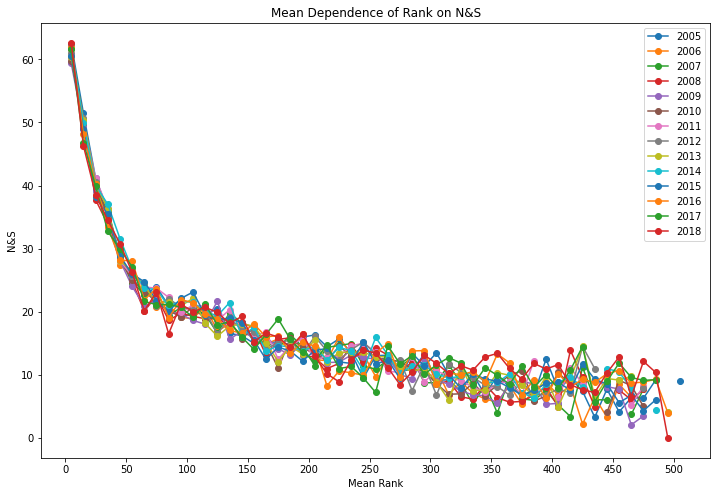

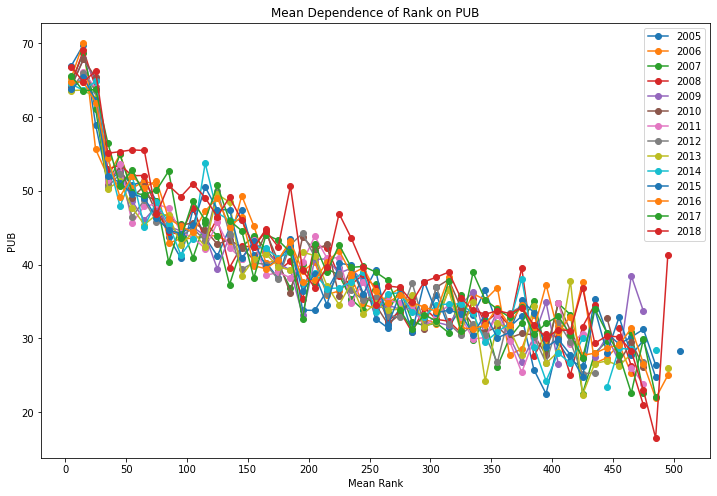

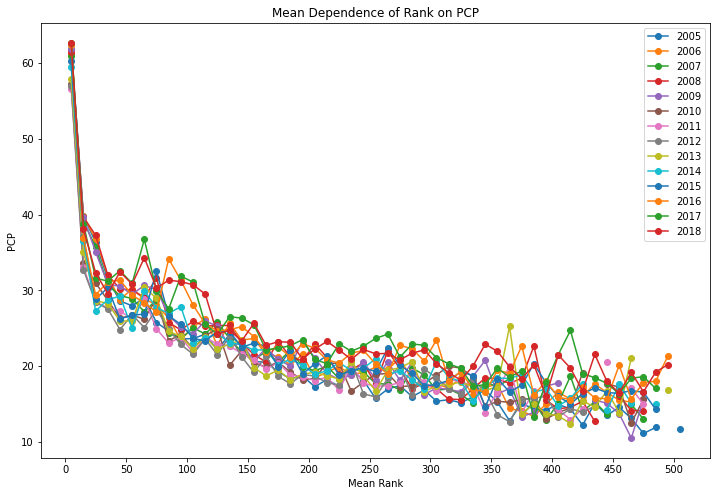

In [16]:
for x in cols[1:]:
    for i,j in data.groupby('Year'):
        ranks = list(range(0,501,10))
        y_data = []
        x_data = []
        j["rank"] = j["World rank"]
        for rank in ranks:
            y_data += [np.mean(np.array(j.query(f"rank>={rank} and rank<={rank+10}")[x]))]
            x_data += [rank+5]
        plt.plot(x_data,y_data,'o-',label=f"{i}")
    plt.title(f"Mean Dependence of Rank on {x}")
    plt.ylabel(f"{x}")
    plt.xlabel("Mean Rank")
    plt.xticks(range(0,501,50))
    plt.legend()
    plt.show()

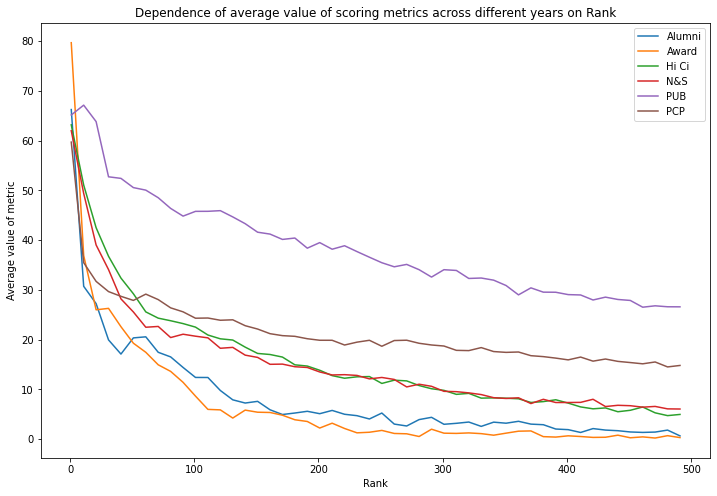

In [17]:
for metric in cols:
  scores = []
  ranks = list(range(1,500,10))
  diff = 10
  for rank in ranks:
    score = 0
    num_scores = 0
    for year in range(min_year,max_year+1):
      score += sum(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)][metric])
      num_scores += len(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)])
    if num_scores != 0:
      avg_score = score/num_scores
    else:
      avg_score = 0
    scores += [avg_score]
  plt.plot(ranks, scores, label = metric)

plt.xlabel('Rank')
plt.ylabel('Average value of metric')
plt.title('Dependence of average value of scoring metrics across different years on Rank')
plt.legend()
pass

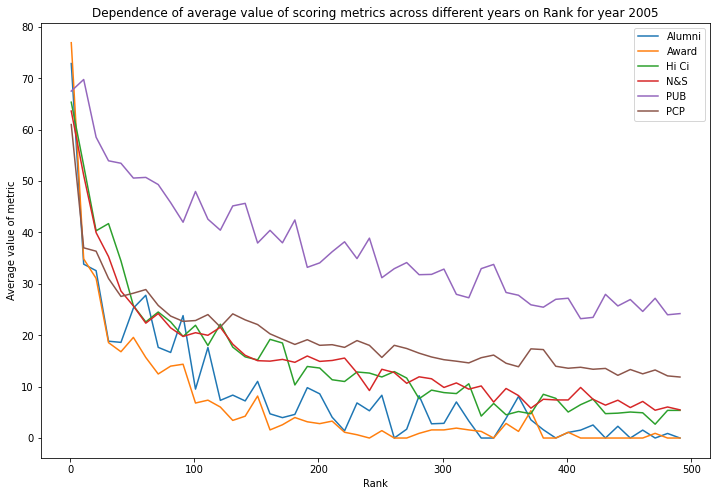

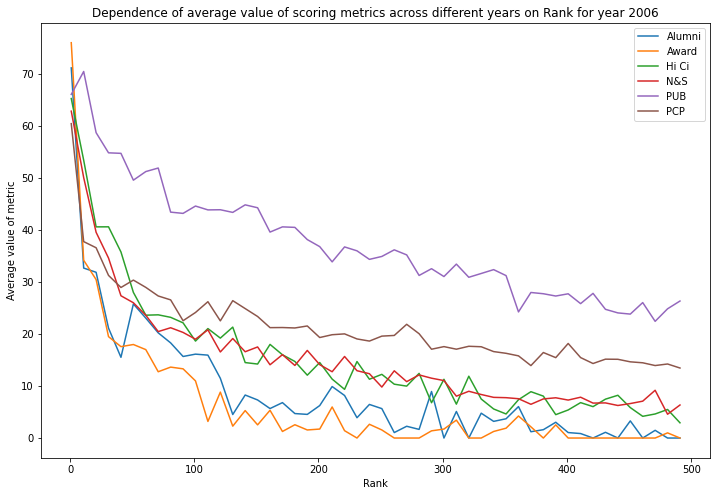

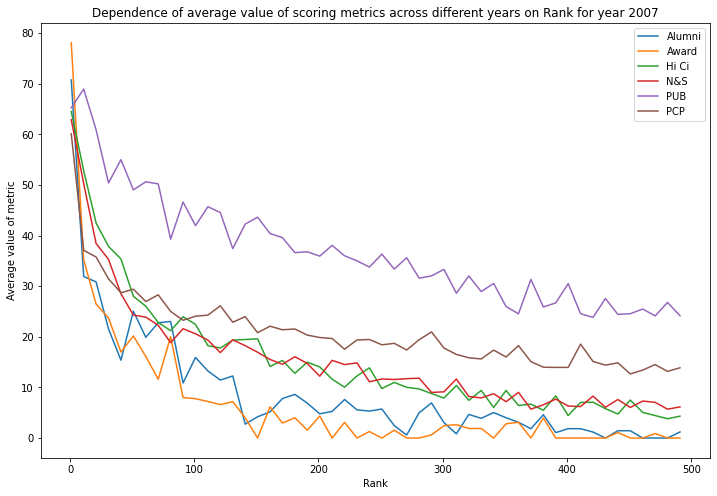

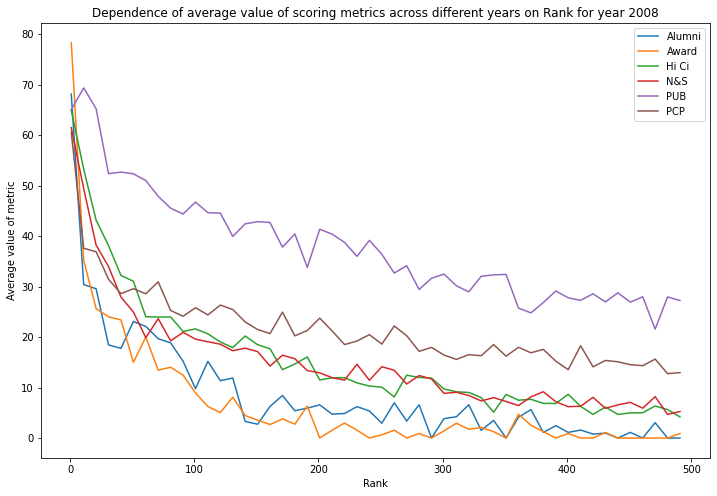

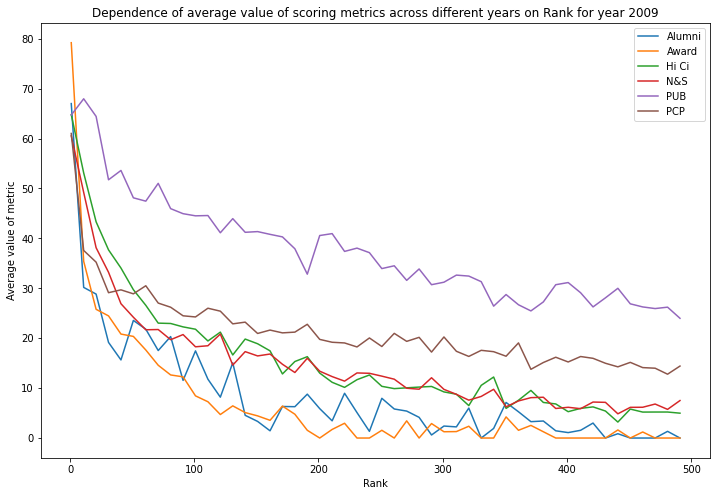

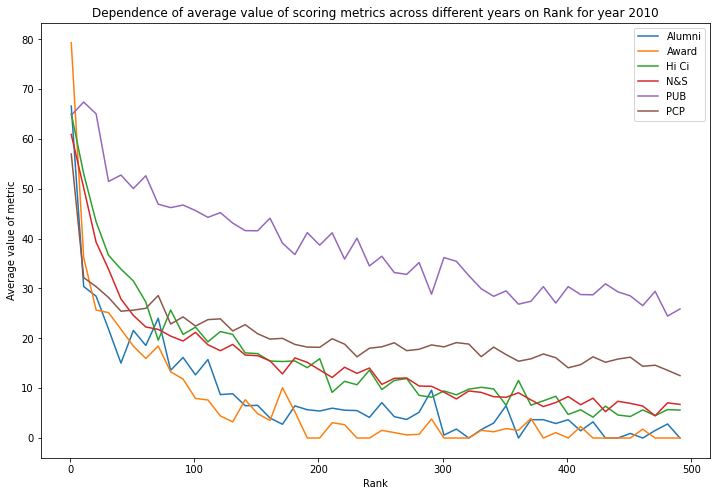

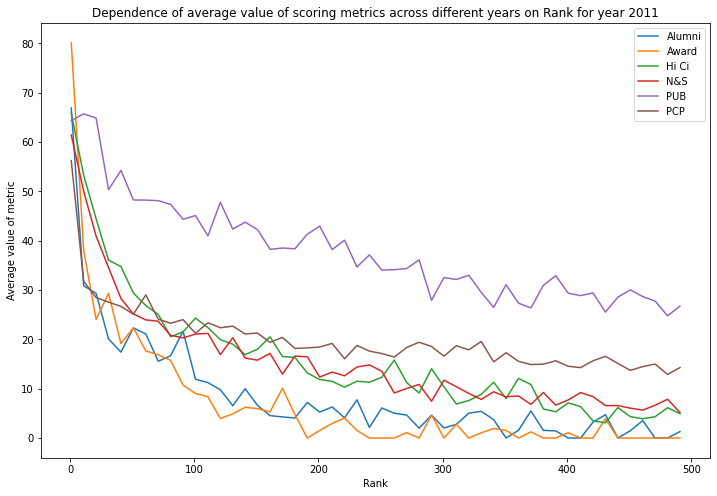

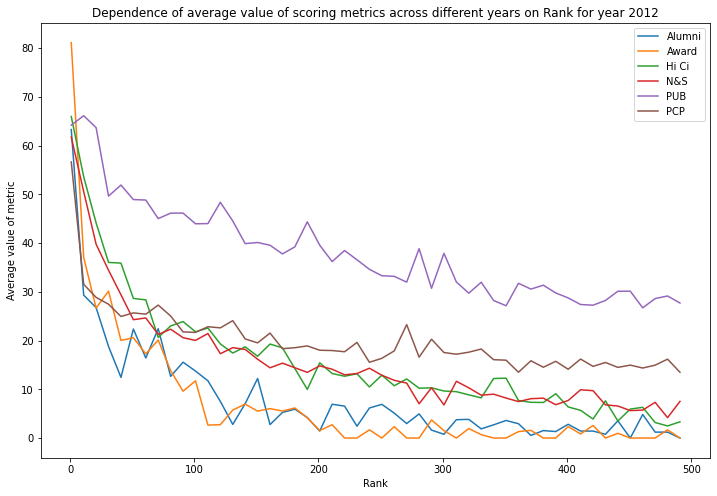

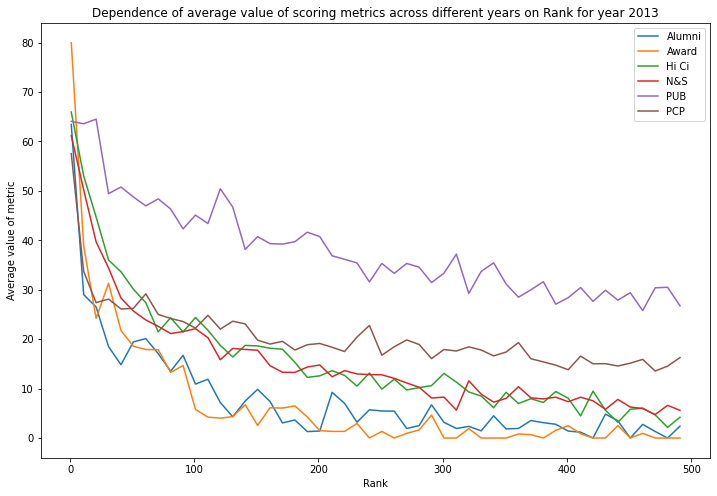

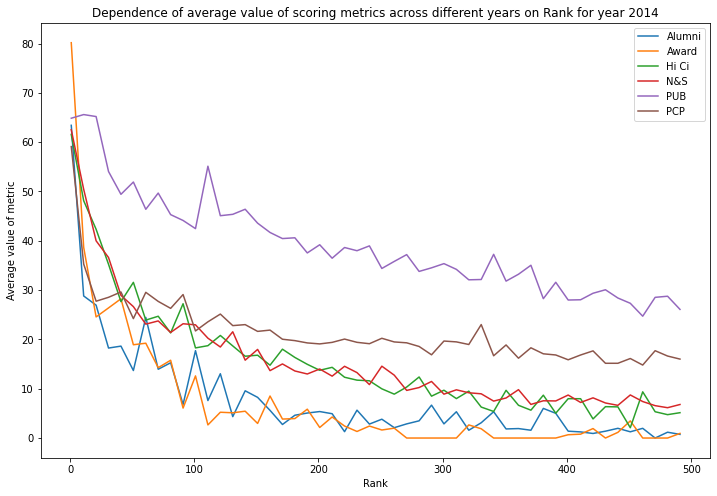

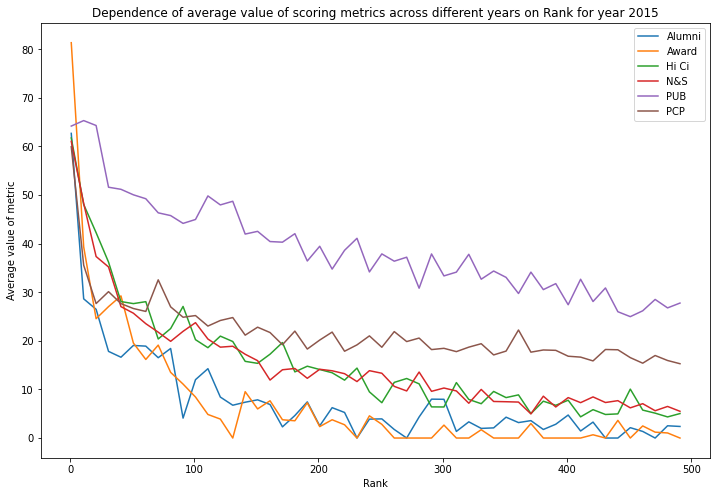

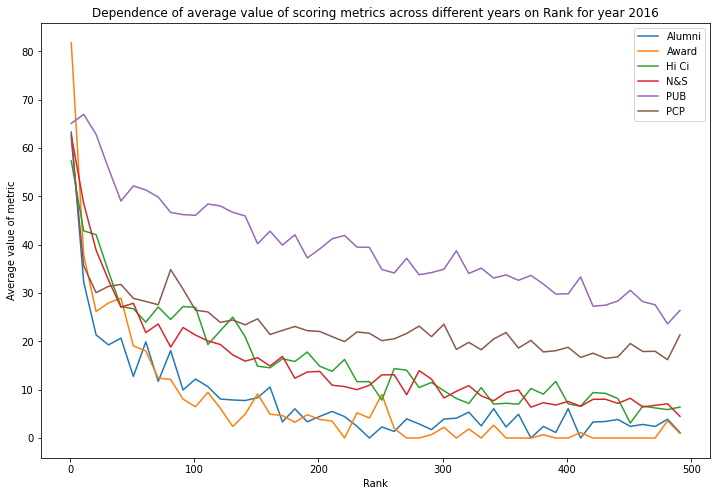

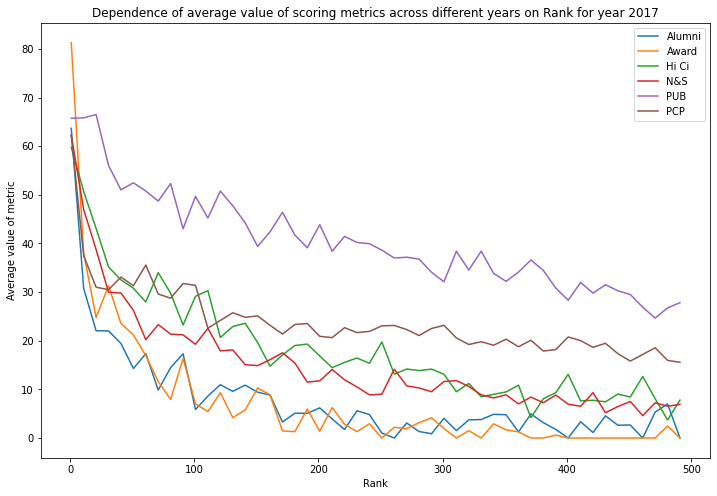

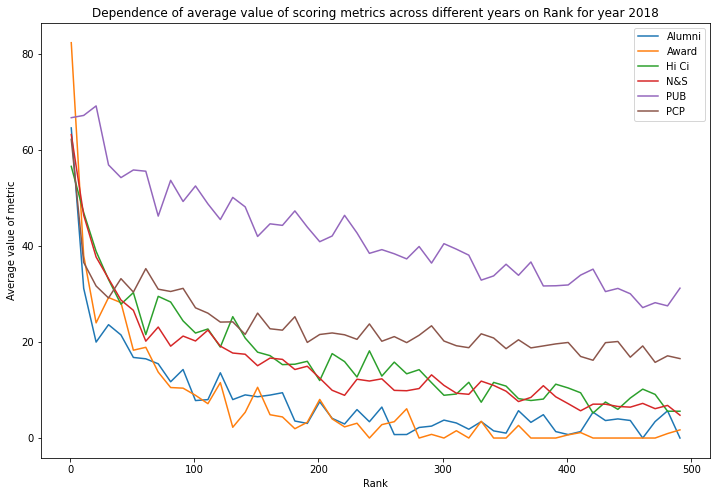

In [18]:
for year in range(min_year,max_year+1):
  for metric in cols:
    scores = []
    ranks = list(range(1,500,10))
    diff = 10
    for rank in ranks:
      score = sum(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)][metric])
      num_scores = len(df[year][np.logical_and(rank <= np.array(df[year]['World rank']), np.array(df[year]['World rank']) <rank+ diff)])
      if num_scores != 0:
        avg_score = score/num_scores
      else:
        avg_score = 0
      scores += [avg_score]
    plt.plot(ranks, scores, label = metric)

  plt.xlabel('Rank')
  plt.ylabel('Average value of metric')
  plt.title(f'Dependence of average value of scoring metrics across different years on Rank for year {year}')
  plt.legend()
  plt.show()
pass

It is noticed having a better ARWU rank corresponds to a higher score in every parameter, hence the score for the parameter decreases with an increase in the rank.

We will now verify using Heatmaps

# Heatmap of the correlation matrix

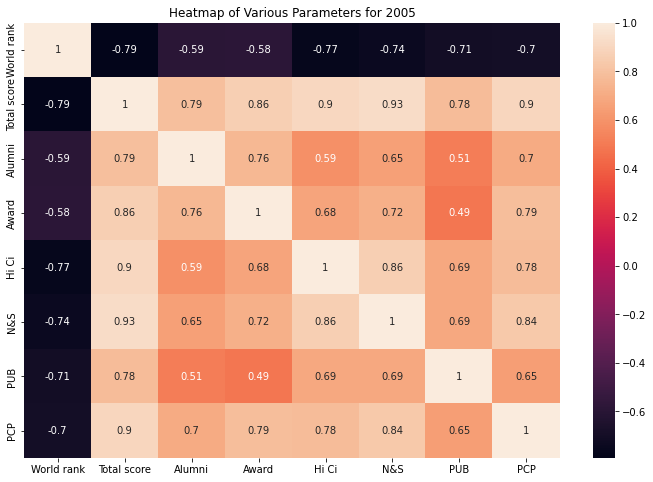

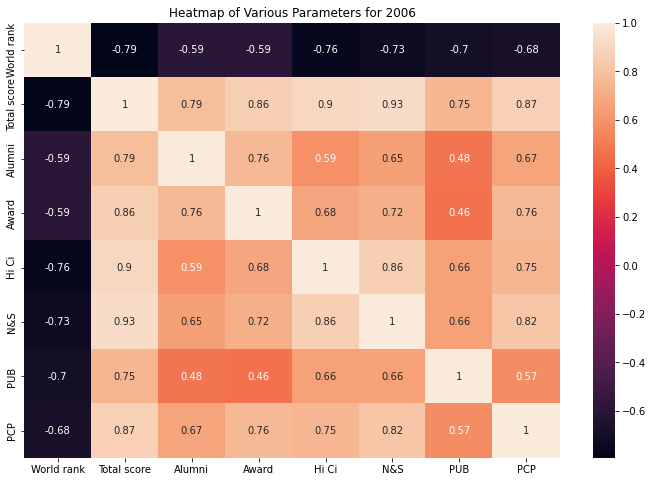

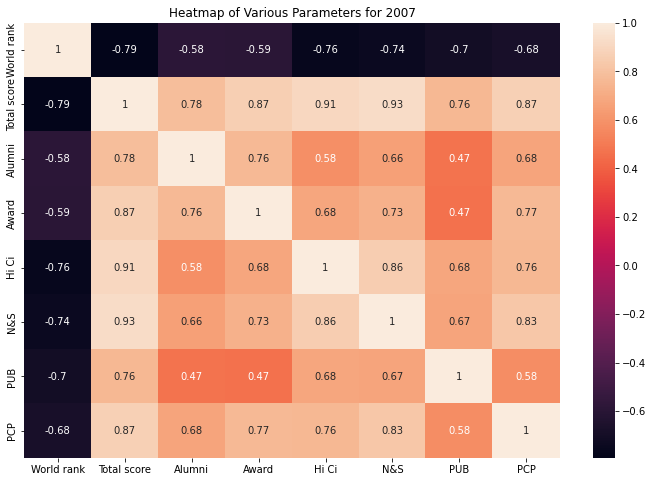

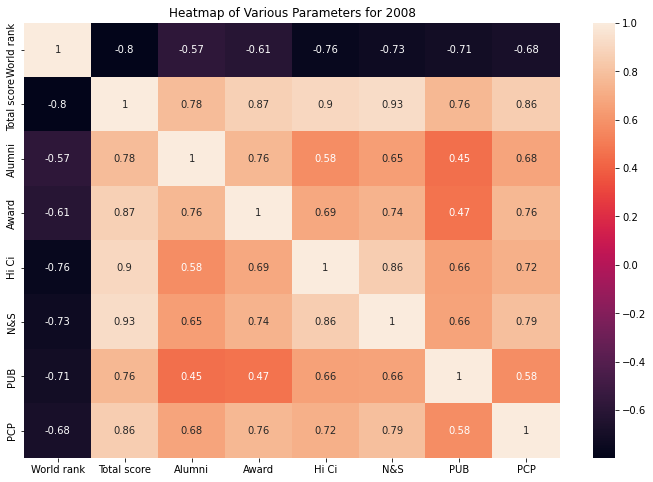

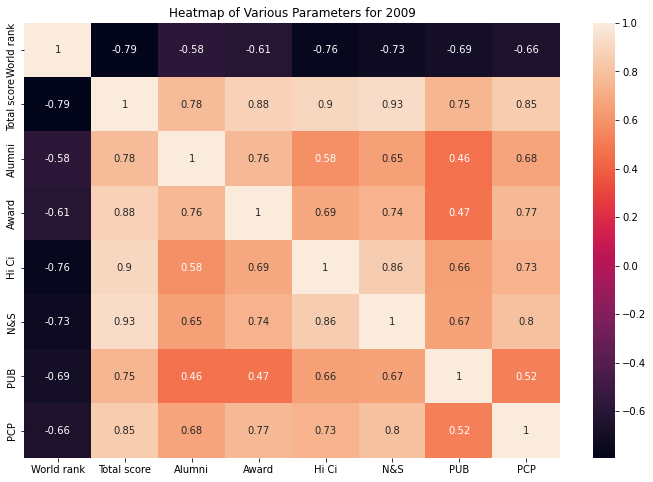

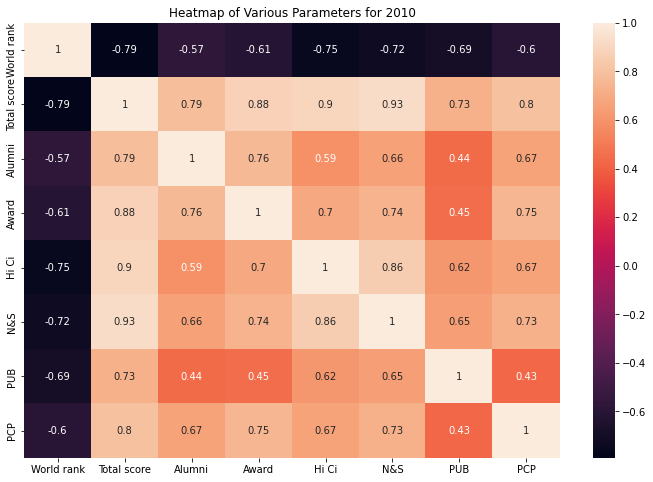

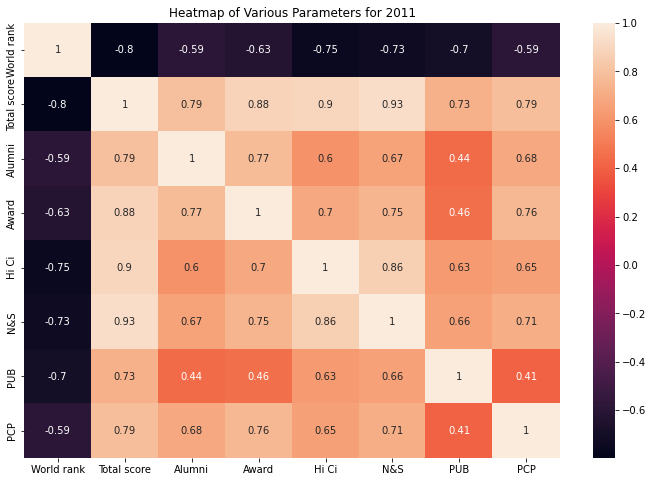

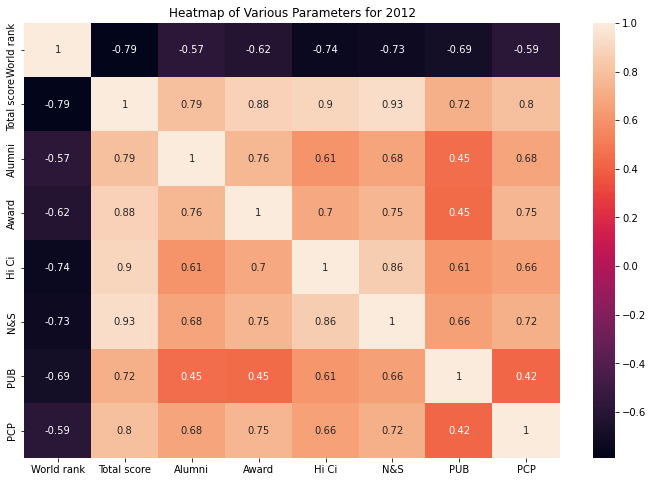

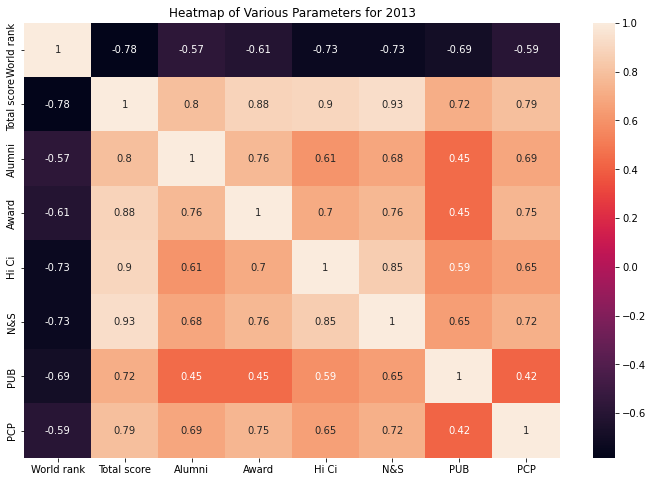

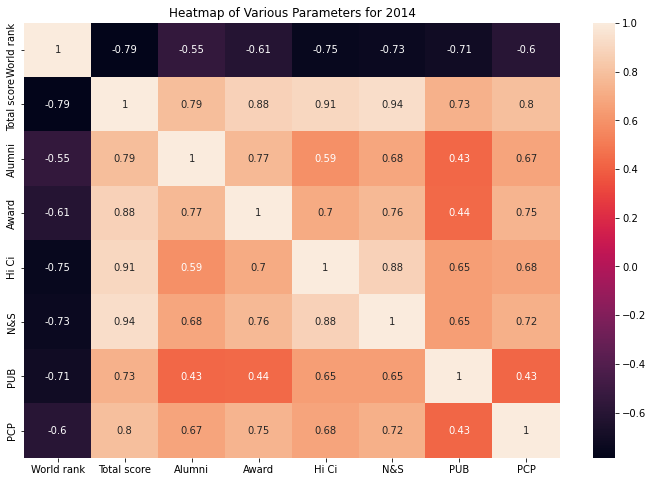

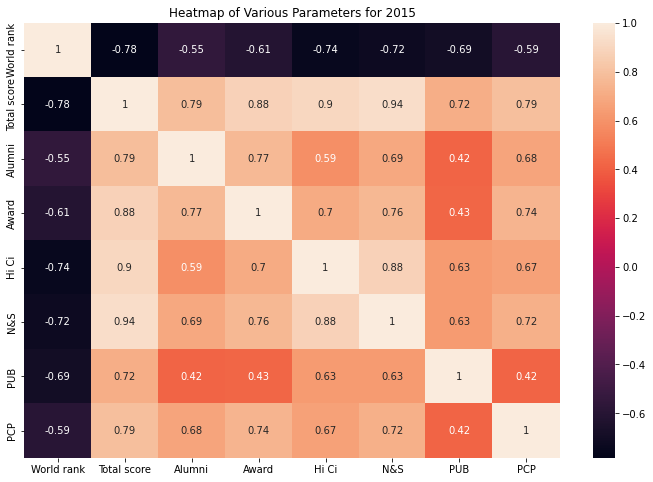

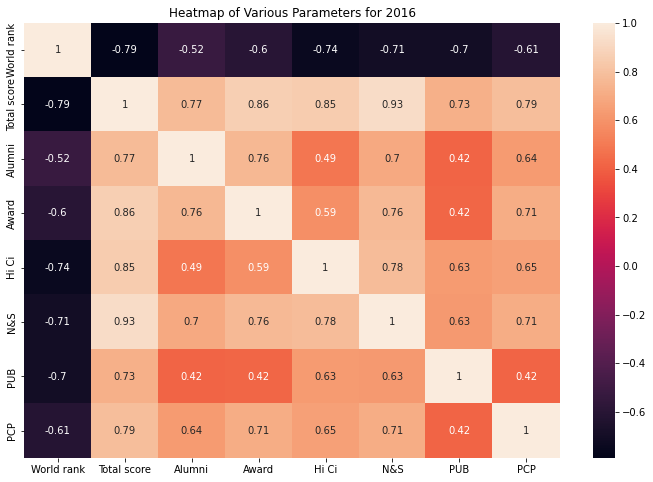

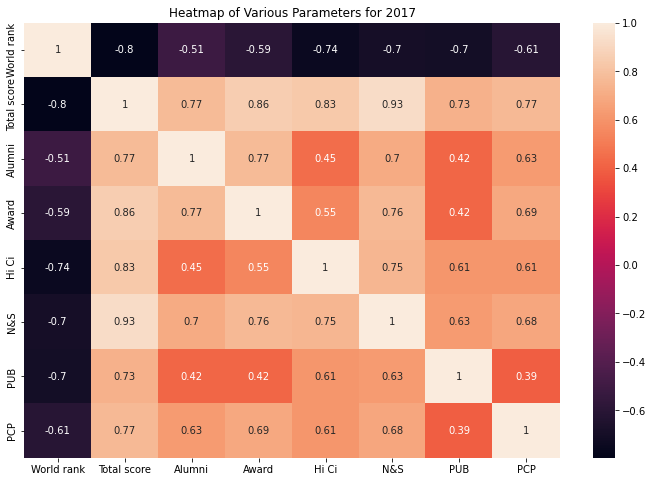

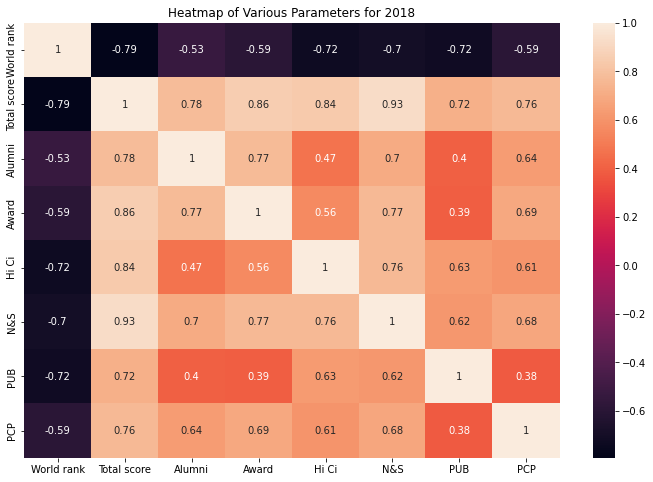

In [19]:
plt.rcParams['figure.figsize'] = [12,8]
k=['World rank','Total score','Alumni','Award','Hi Ci','N&S','PUB','PCP']
for i,j in data.groupby('Year'):
    plt.title(f"Heatmap of Various Parameters for {i}")
    sns.heatmap(j[k].corr(),annot=True)
    plt.show()

We notice here that the world rank (AWRU Rank) has very high negative correlation with all the parameters => if the parameters increase, then the AWRU rank decreases.

Also since most of the parameters are very positively correlated with each other, means some of them could be redundant unlike in the case of NIRF and QS

# Trends for top 10 ranked universities

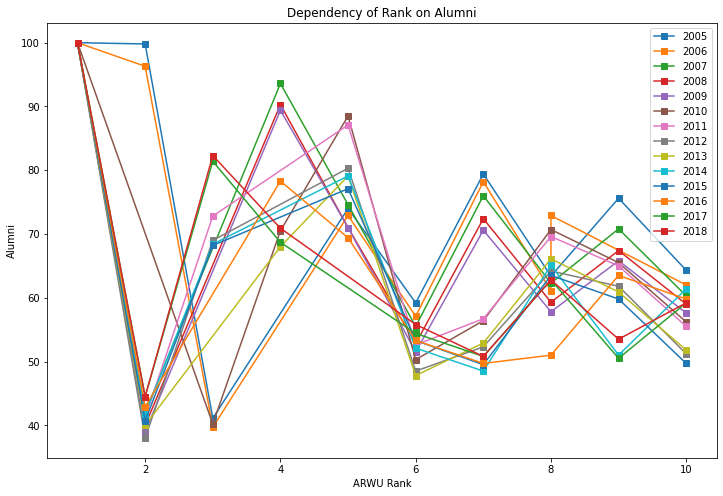

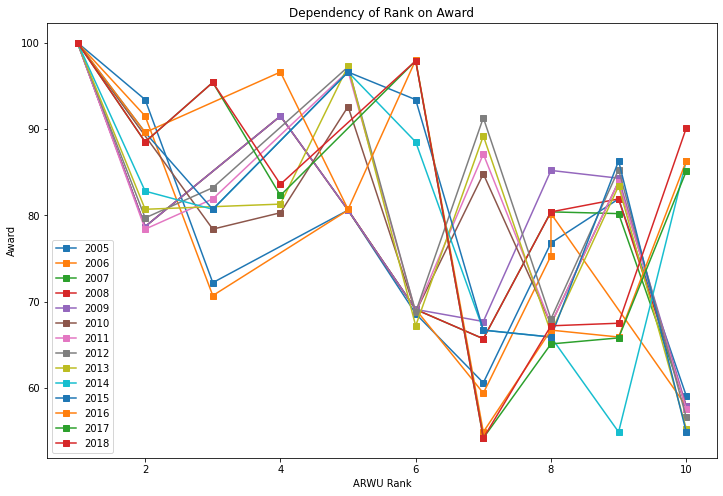

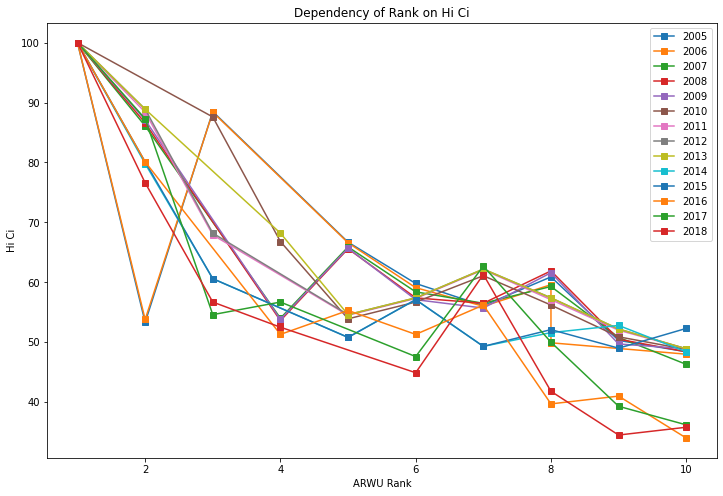

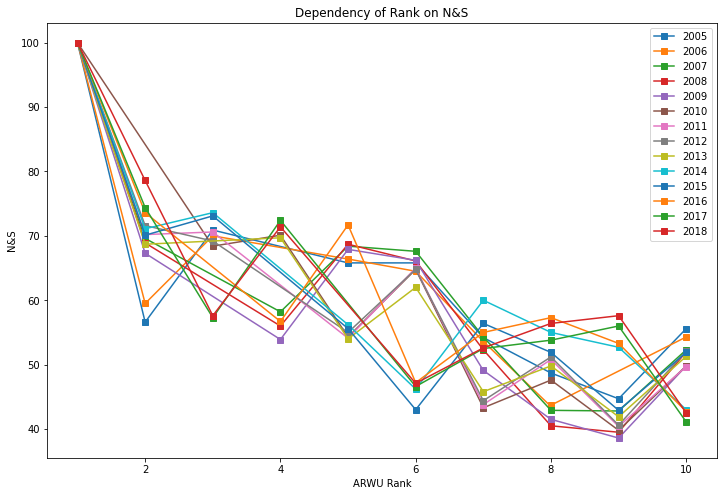

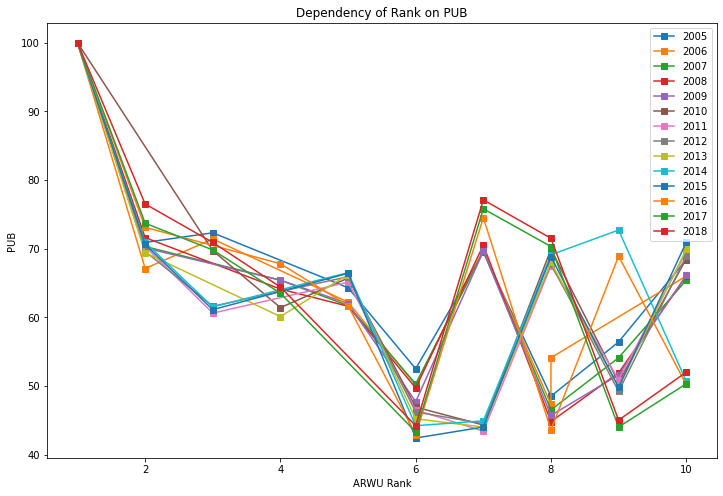

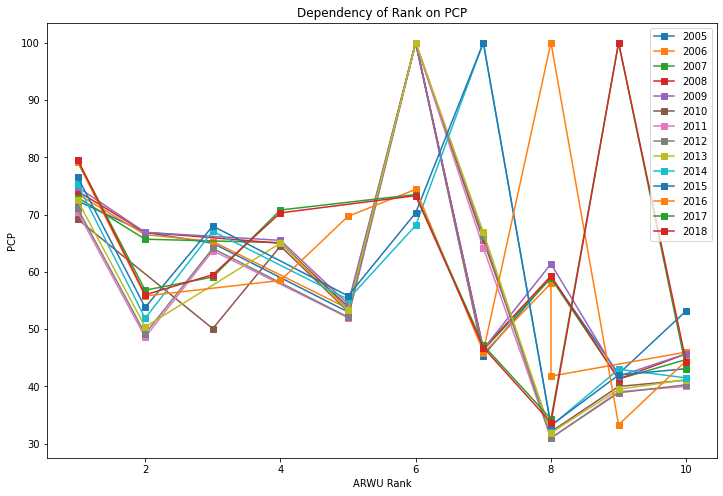

In [20]:
plt.rcParams['figure.figsize'] = [12,8]
top10data = data.query("`World rank` <= 10")
k = [i for i in cols if i!="World rank"]
for x in k:
    for i,j in top10data.groupby('year'):
        plt.plot(j['World rank'],j[f"{x}"],'s-',label=f"{i}")
    plt.title(f"Dependency of Rank on {x}")
    plt.ylabel(f"{x}")
    plt.xlabel("ARWU Rank")
    plt.legend()
    plt.show()

These are the trends of parameters for only the first 10 ranks and follow a similar behaviour to what we had observed for the entire dataset

In [21]:
top102020 = data.query("year==2018")
top102020 = list(top102020.head(10)['University'])
print(top102020)

['Harvard University', 'Stanford University', 'University of Cambridge', 'Massachusetts Institute of Technology (MIT)', 'Princeton University', 'University of Oxford', 'Columbia University', 'California Institute of Technology', 'University of Chicago', 'University of California, Los Angeles']


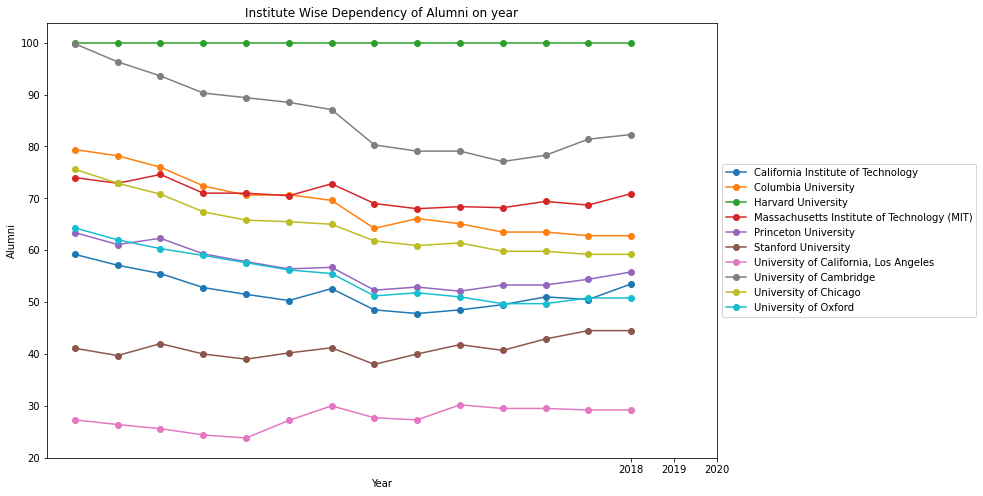

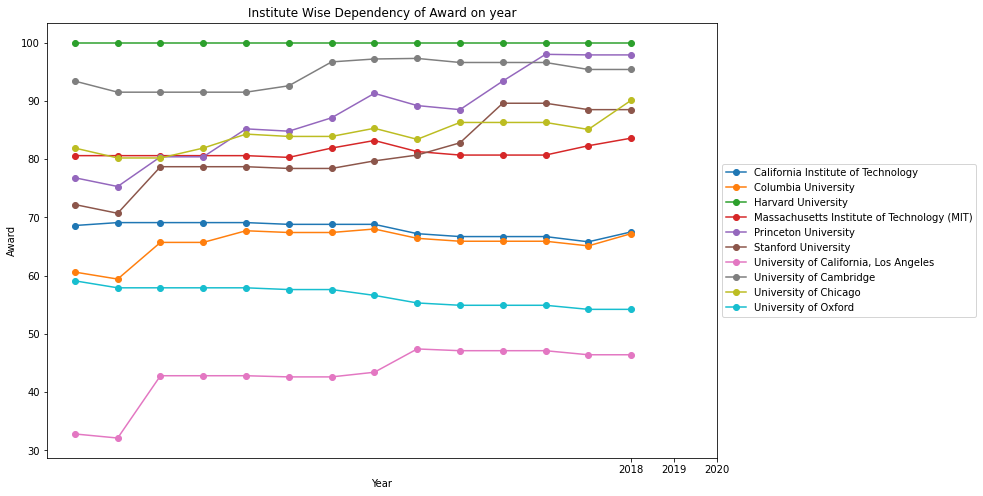

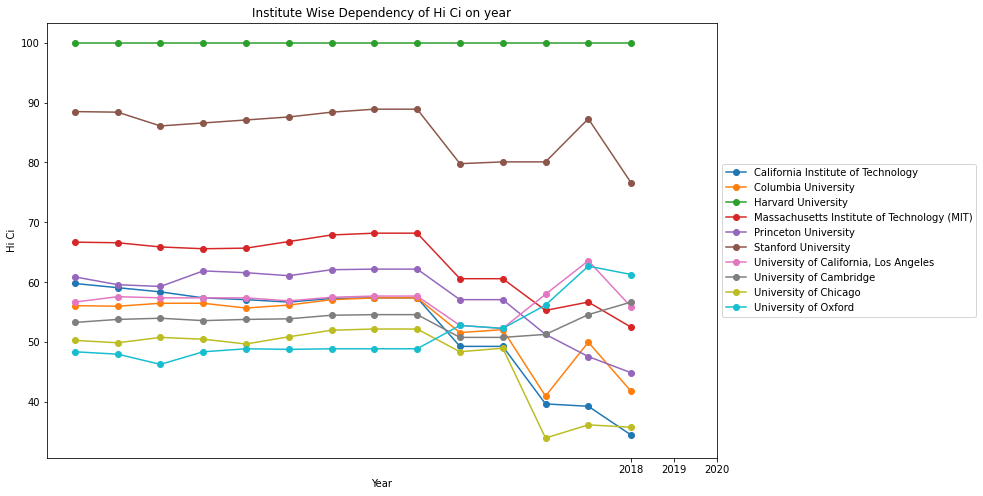

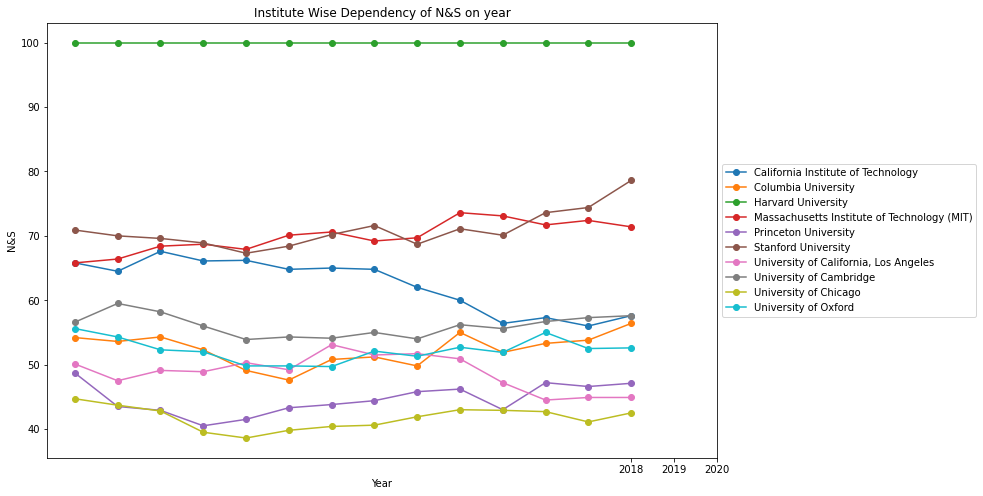

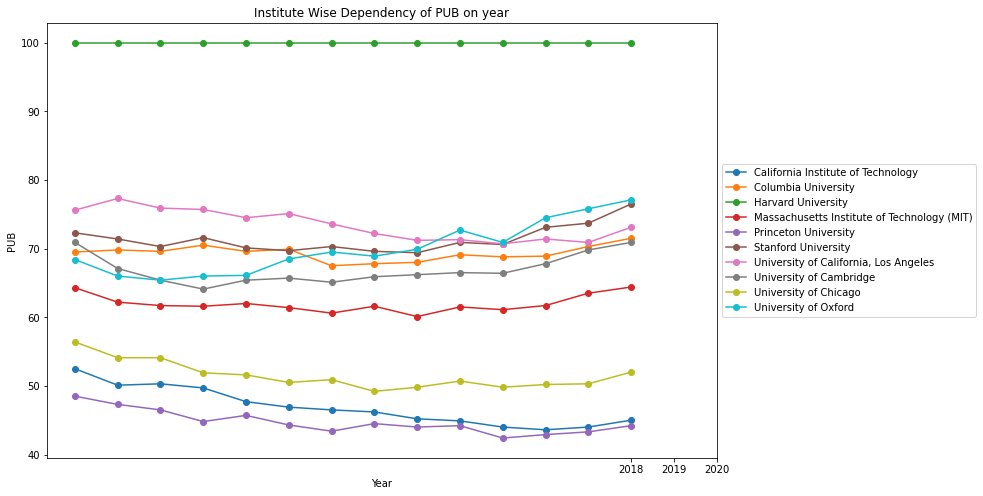

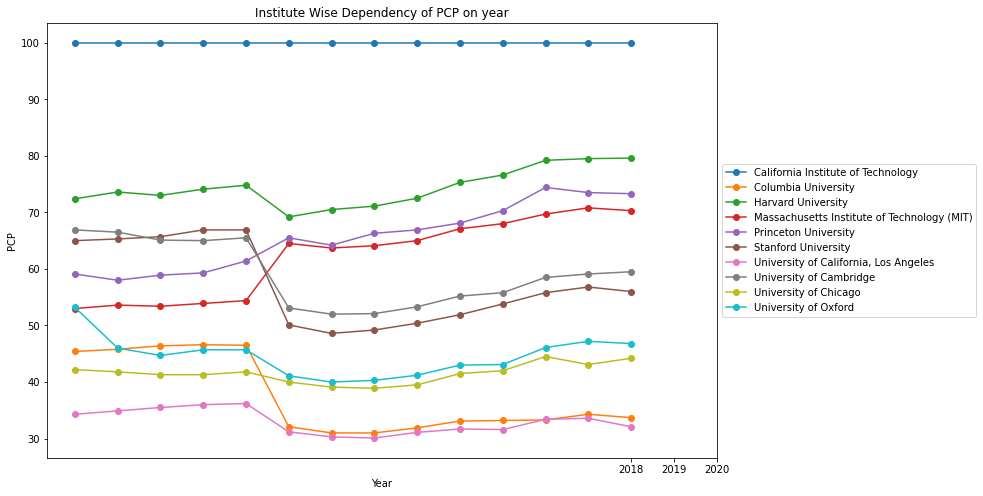

In [22]:
h = cols
for val in h:
    for i,j in data.groupby('University'):
        if(i in top102020):
            plt.plot(j['year'],j[f'{val}'],'o-',label=f"{i}")
    plt.title(f"Institute Wise Dependency of {val} on year")
    plt.ylabel(f"{val}")
    plt.xlabel("Year")
    plt.xticks([2018,2019,2020])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

These are the trends of parameters for only the first 10 ranks and follow a similar behaviour to what we had observed for the entire dataset

# Geographical Location

In [26]:
!pip install pycountry_convert

     |████████████████████████████████| 10.1 MB 7.0 MB/s 
     |████████████████████████████████| 213 kB 32.8 MB/s 
     |████████████████████████████████| 280 kB 76.7 MB/s 
     |████████████████████████████████| 280 kB 78.0 MB/s 
     |████████████████████████████████| 280 kB 73.6 MB/s 
     |████████████████████████████████| 280 kB 77.7 MB/s 
     |████████████████████████████████| 279 kB 74.1 MB/s 
     |████████████████████████████████| 279 kB 79.8 MB/s 
     |████████████████████████████████| 272 kB 80.1 MB/s 
     |████████████████████████████████| 272 kB 73.7 MB/s 
     |████████████████████████████████| 272 kB 58.9 MB/s 
     |████████████████████████████████| 270 kB 76.8 MB/s 
     |████████████████████████████████| 270 kB 77.0 MB/s 
     |████████████████████████████████| 270 kB 78.5 MB/s 
     |████████████████████████████████| 248 kB 76.1 MB/s 
     |████████████████████████████████| 247 kB 67.3 MB/s 
     |████████████████████████████████| 246 kB 61.5 MB/s 
     |████████

In [27]:
import pycountry_convert as pc

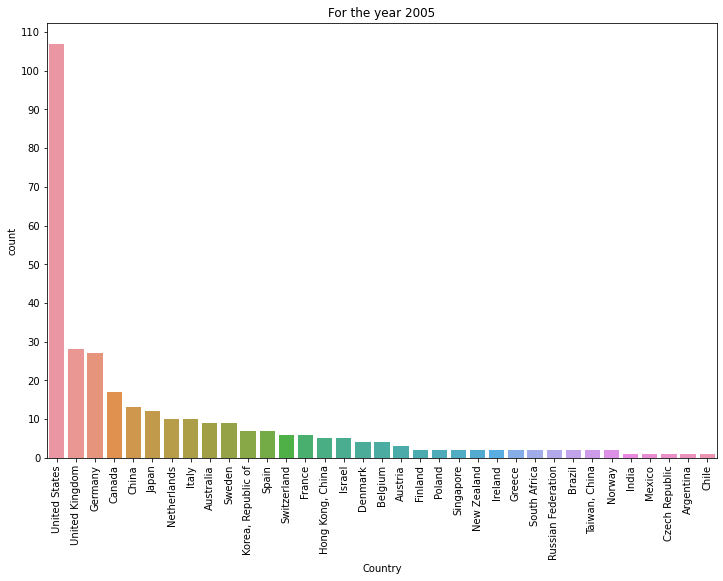

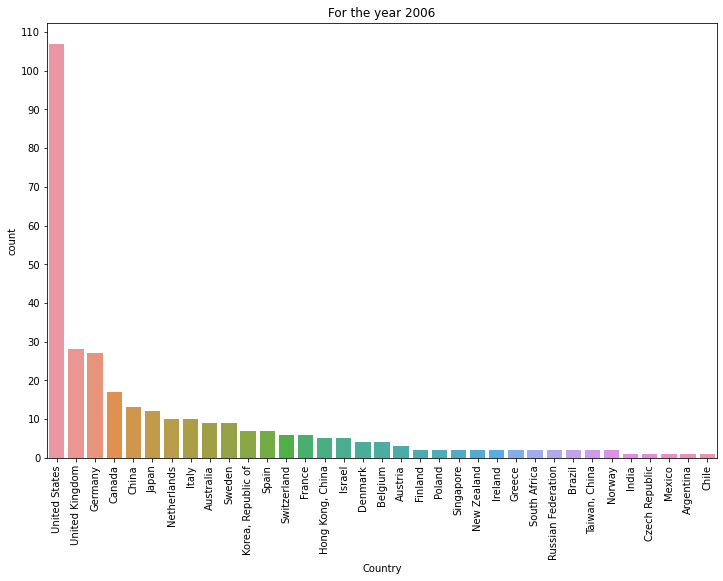

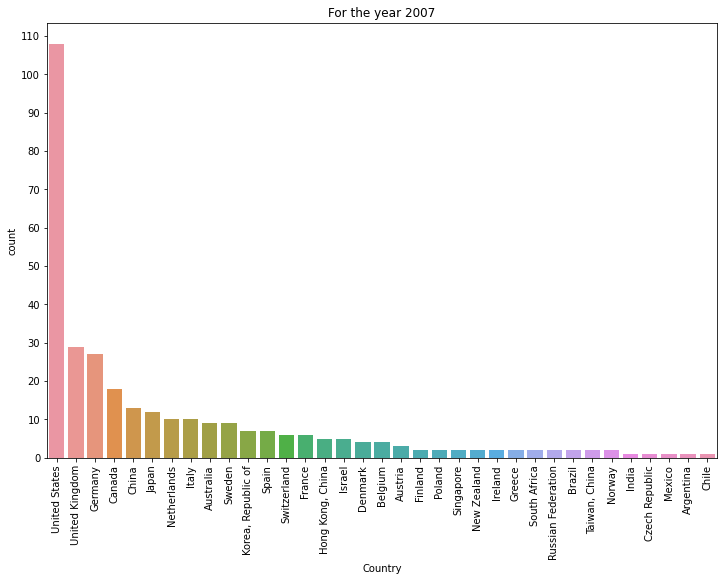

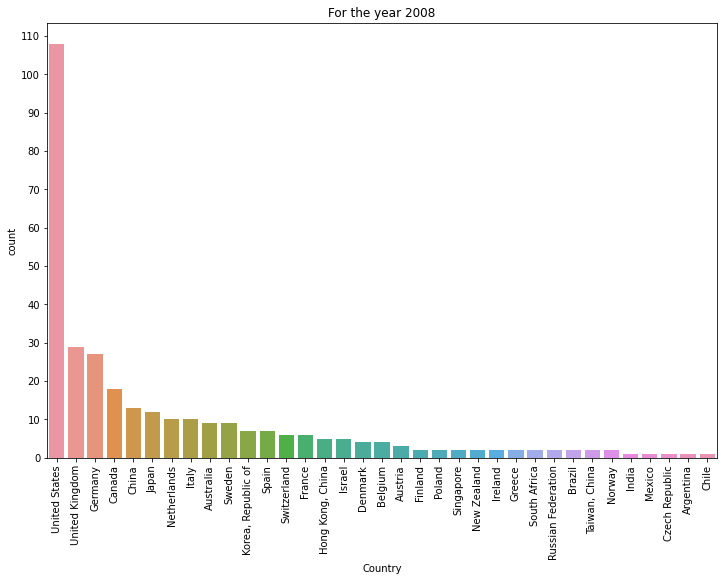

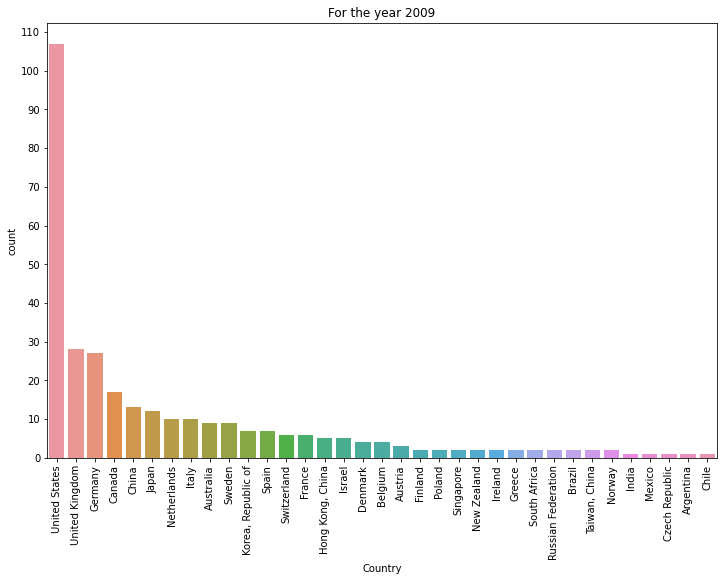

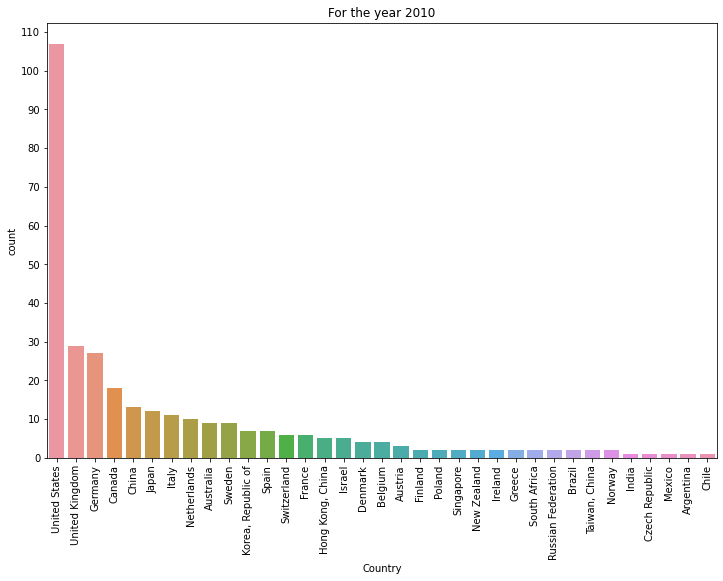

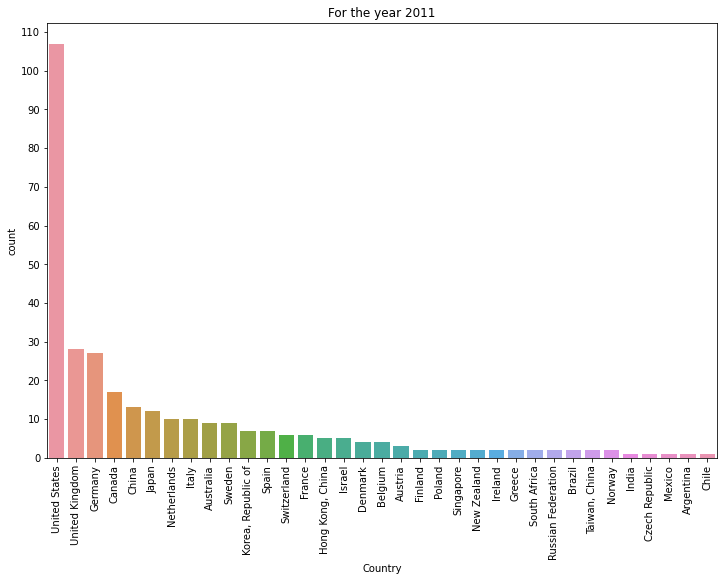

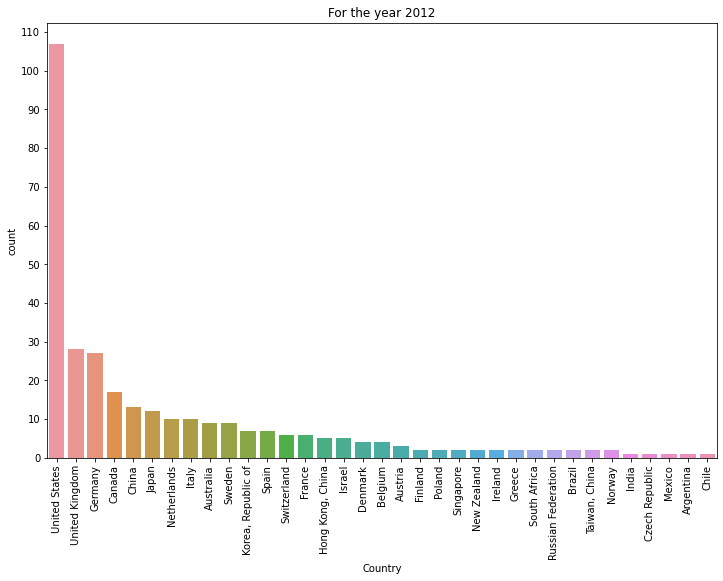

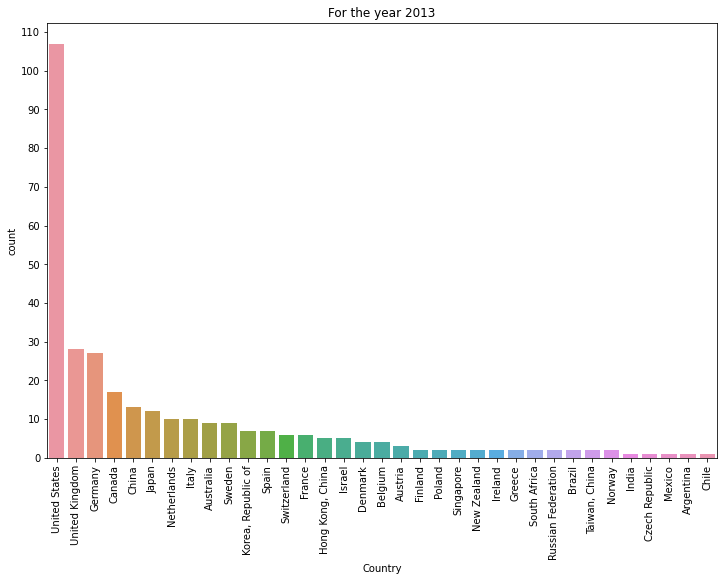

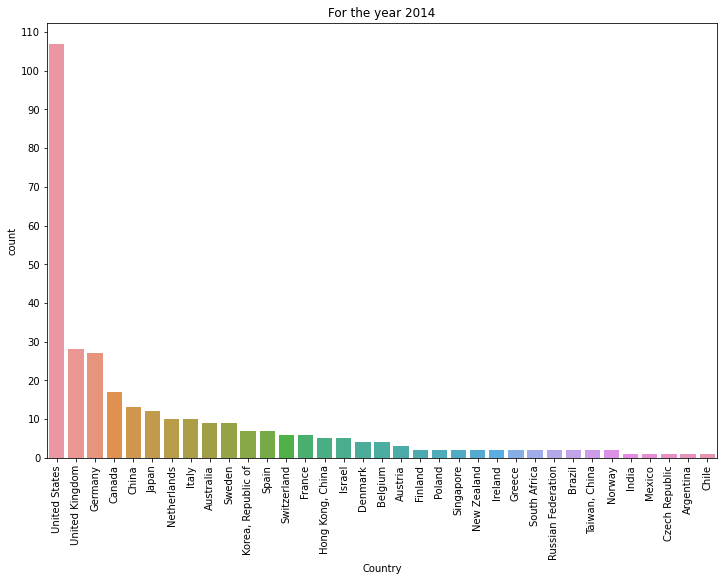

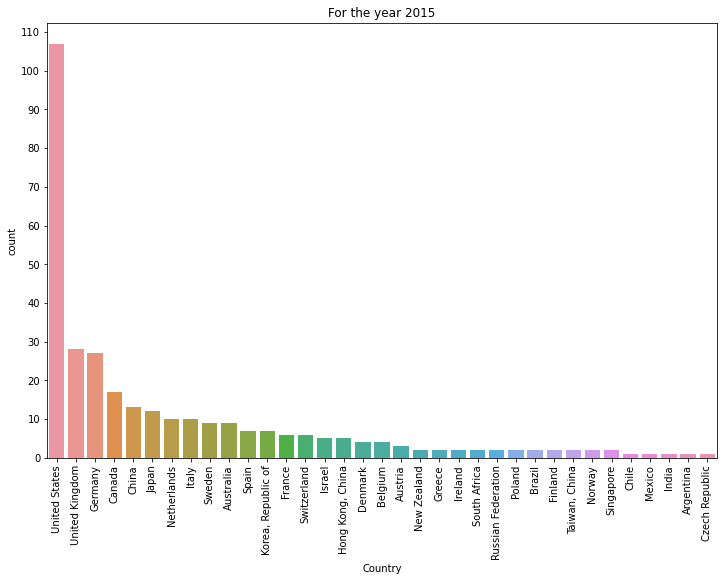

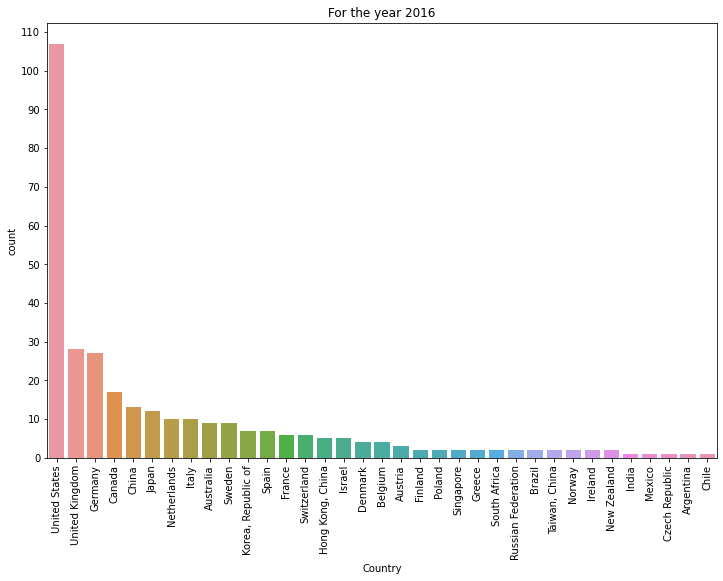

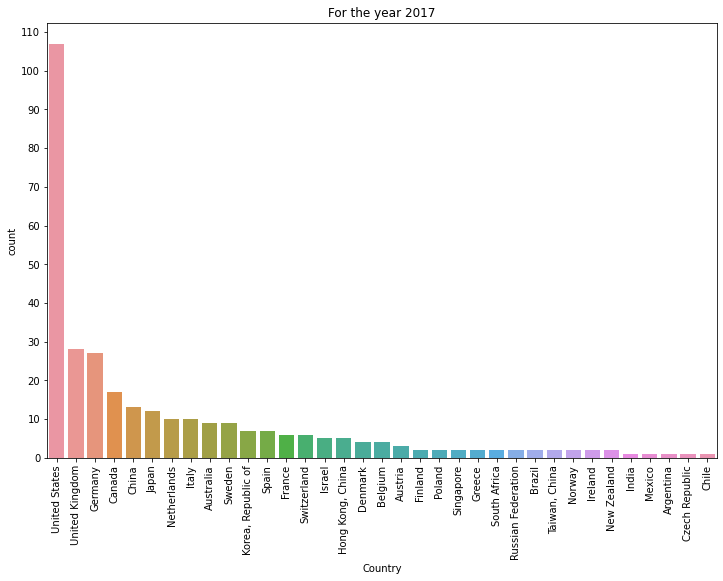

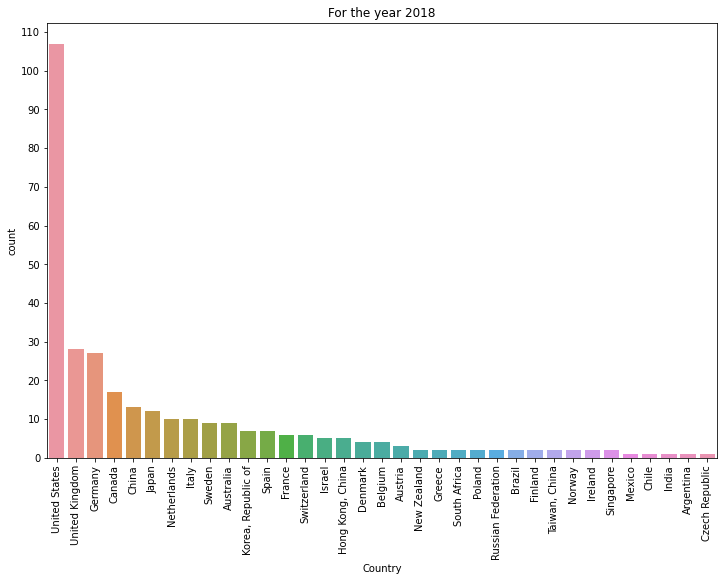

In [28]:
## Country wise Histogram
plt.rcParams['figure.figsize'] = [12,8]
for i,j in data.groupby('Year'):
    val = j
    plt.title(f"For the year {i}")
    plt.xticks(rotation='vertical')
    plt.yticks(range(0,120,10))
    plt.xlabel("Country")
    plt.ylabel("No of colleges")
    sns.countplot(val['Country'],order = val['Country'].value_counts().index)
    plt.show()

From the histogram it is evident that USA, UK and Germany have a large number of top ranked universities

## Dynamic trends in Geographic Distribution

In [29]:
def country_to_continent(country):
  if ',' in country:
    i = country.index(',')
    country = country[:i]
  if country == 'Korea':
    return 'Asia'
  country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
  continent_name = pc.country_alpha2_to_continent_code(country_code)
  continents = {
      'NA': 'North America',
      'SA': 'South America', 
      'AS': 'Asia',
      'OC': 'Australia',
      'AF': 'Africa',
      'EU': 'Europe'
  }
  return continents[continent_name]

In [ ]:
for year in  range(min_year,max_year+1):
  df[year]['Continent'] = df[year]['Country'].apply(country_to_continent)

In [ ]:
continents = [
      'North America',
      'South America', 
      'Europe',
      'Africa',
      'Asia',
      'Australia',
]

continent_info = {}
for year in range(min_year,max_year+1):
  scores = {}
  num_univs = {}
  for continent in continents:
    scores[continent] = 0
    num_univs[continent] = 0
  for i in range(len(df[year])):
    scores[df[year]['Continent'][i]] += df[year]['Total score'][i]
    num_univs[df[year]['Continent'][i]] += 1
  continent_info[year] = {'scores':scores, 'num_univs':num_univs}

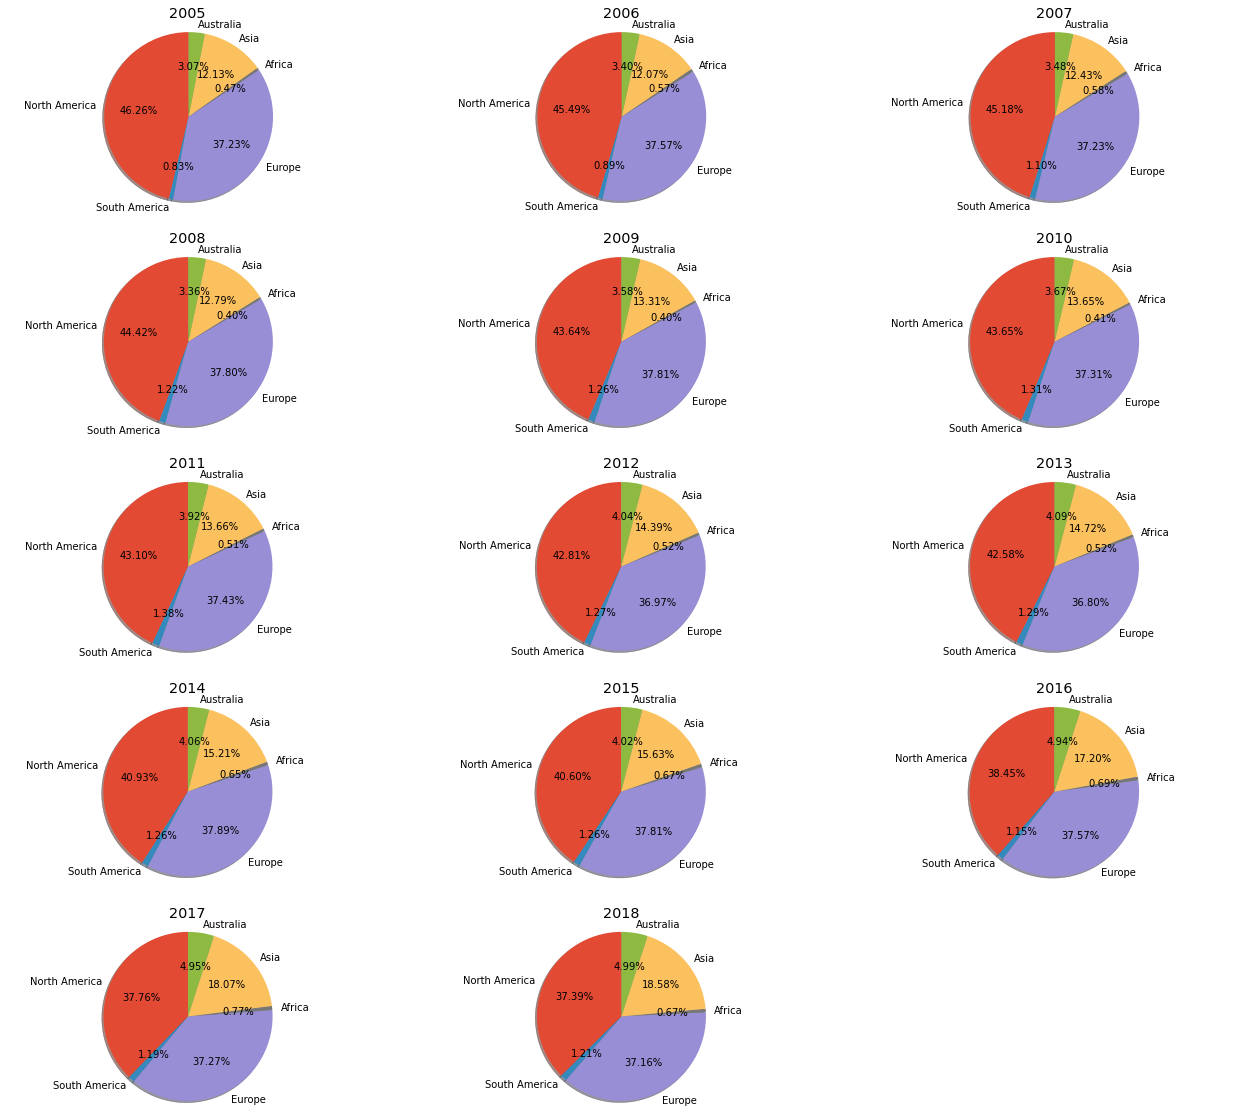

In [ ]:
# Total score of univs in a continent
plt.rcParams['figure.figsize'] = [22,20]
plt.style.use('ggplot')
count=1
for year in range(min_year,max_year+1):
  labels = continents
  sizes = [continent_info[year]['scores'][continent] for continent in continents]

  ax1 = plt.subplot(5,3,count)
  ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(str(year))
  count+=1
plt.show()

### **The above pi charts show the distrbution of cumulative total scores of all universities in a continent**
- The share of **North American** universities have **decreased significantly** from 46.3 % in min_year to 37.4% in max_year.
- The share of **European** Universities have **remained** pretty much **constant** through the years. 
- The share of **South American** universities **increased slightly** from 0.8% to around 1.2% and has remained pretty much **constant in later years**.
- The **Asian and Australian universities** have steadily grown in shares. Asia went from 12.1% to 18.6% while Australia went from 3.1% to 5%.
- Even **Africa** has shown **slight improvements** going from 0.47% to 0.67% in peaking at around 0.77%.
- Europe might overtake N America
> **The trends show that the education quality is slowly shifting from the west to the east**.

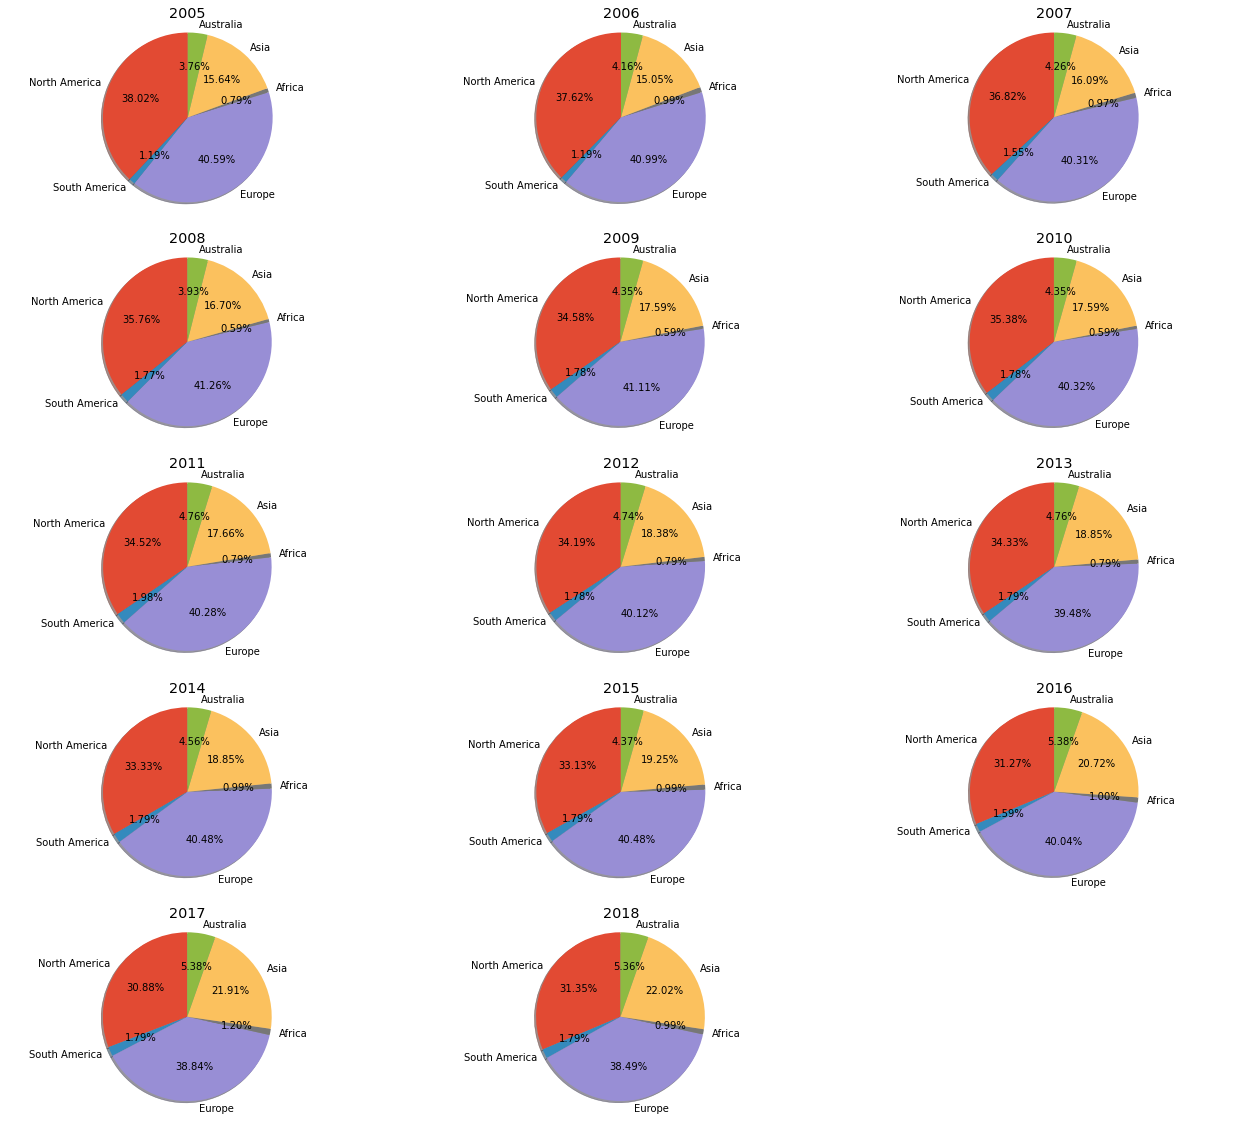

In [ ]:
# Number of universities vs continent
plt.rcParams['figure.figsize'] = [22,20]
count=1
for year in range(min_year,max_year+1):
  labels = continents
  sizes = [continent_info[year]['num_univs'][continent] for continent in continents]

  ax1 = plt.subplot(5,3,count)
  ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(str(year))
  count+=1
plt.show()

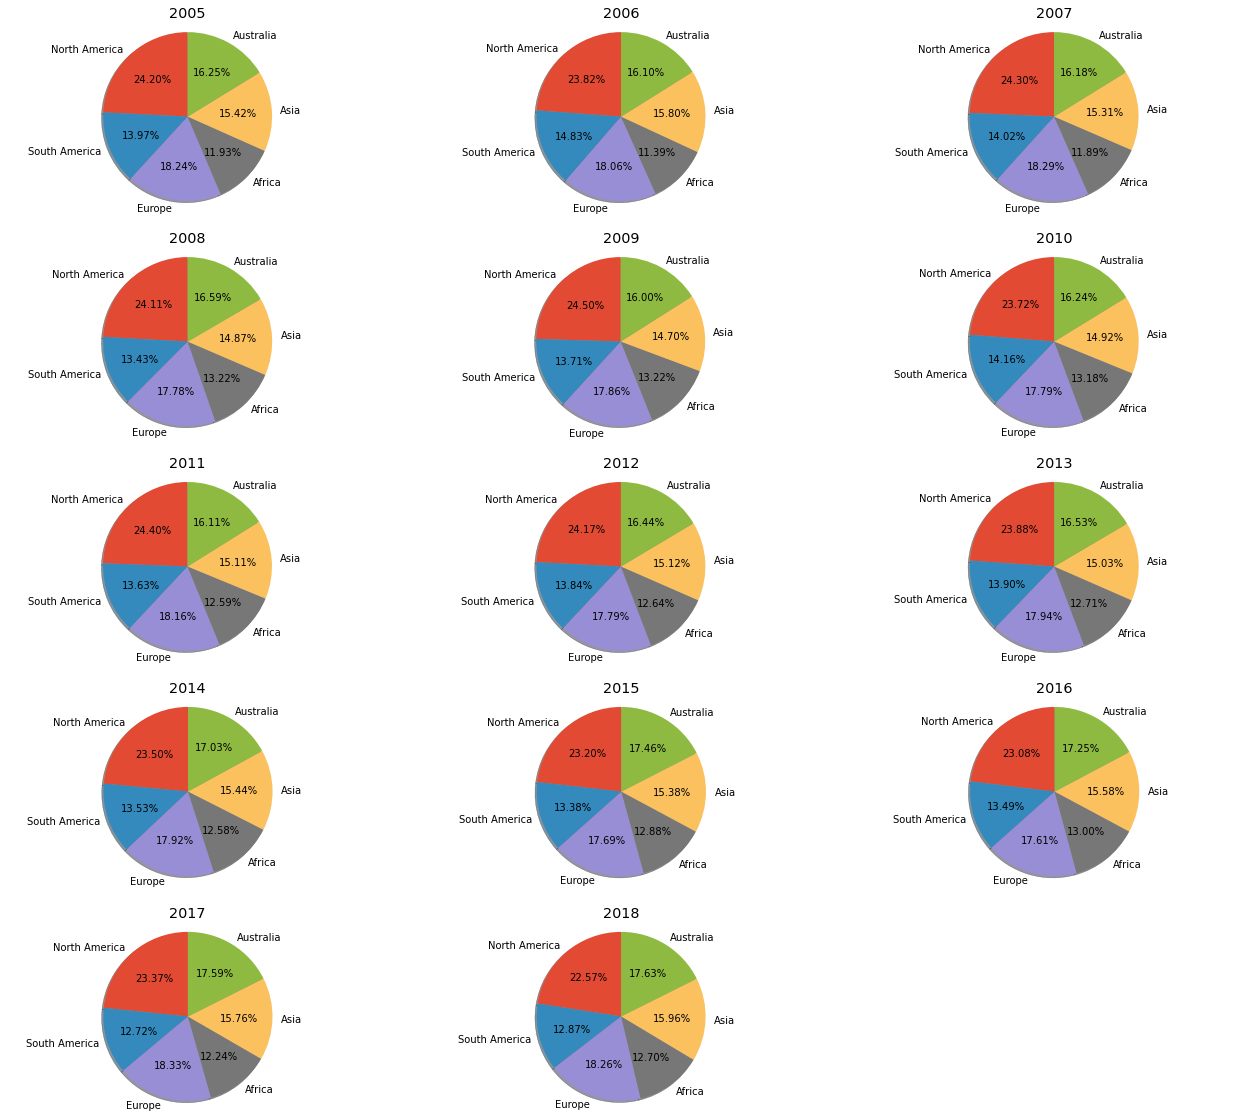

In [ ]:
# Average university score vs continent

plt.rcParams['figure.figsize'] = [22,20]
count=1
for year in range(min_year,max_year+1):
  labels = continents
  sizes = [continent_info[year]['scores'][continent]/continent_info[year]['num_univs'][continent] for continent in continents]
  ax1 = plt.subplot(5,3,count)
  ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title(str(year))
  count+=1
plt.show()

# Predictive Analysis for ARWU Dataset (Shanghai Rankings)

In [ ]:
data_test=pd.DataFrame()
data_train=pd.DataFrame()
data_val=pd.DataFrame()

for i in df.keys():
    df[i]['year']=i
    if i==2017:
        data_val=data_val.append(df[i])
    elif i==2018:
        data_test=data_test.append(df[i])
    else:
        data_train=data_train.append(df[i])

test=[]
train=[]
test_final=[]
for i in a:
    test_final.append(data_test[data_test['University']==i])
    test.append(data_val[data_val['University']==i])
    train.append(data_train[data_train['University']==i])
    
for i in range(len(train)):
    if len(train[i])==24: #To fix redundant data in a few universities
        temp=pd.DataFrame()
        for j in range(24):
            if j%2==0:
                temp=temp.append(train[i].iloc[j])
        train[i]=temp
    if len(train[i])==14:
        temp=pd.DataFrame()
        for j in range(14):
            if j!=3 and j!=5:
                temp=temp.append(train[i].iloc[j])
        train[i]=temp
    if len(train[i])==13:
        temp=pd.DataFrame()
        for j in range(13):
            if j!=6:
                temp=temp.append(train[i].iloc[j])
        train[i]=temp
        
for i in range(len(test)):
    if len(test[i])==24: 
        temp=pd.DataFrame()
        for j in range(24):
            if j%2==0:
                temp=temp.append(test[i].iloc[j])
        test[i]=temp
    if len(test[i])==14:
        temp=pd.DataFrame()
        for j in range(14):
            if j!=3 and j!=5:
                temp=temp.append(test[i].iloc[j])
        test[i]=temp
    if len(test[i])==13:
        temp=pd.DataFrame()
        for j in range(13):
            if j!=6:
                temp=temp.append(test[i].iloc[j])
        test[i]=temp
        
for i in range(len(test_final)):
    if len(test_final[i])==24:  
        temp=pd.DataFrame()
        for j in range(24):
            if j%2==0:
                temp=temp.append(test_final[i].iloc[j])
        test_final[i]=temp
    if len(test_final[i])==14:
        temp=pd.DataFrame()
        for j in range(14):
            if j!=3 and j!=5:
                temp=temp.append(test_final[i].iloc[j])
        test_final[i]=temp
    if len(test_final[i])==13:
        temp=pd.DataFrame()
        for j in range(13):
            if j!=6:
                temp=temp.append(test_final[i].iloc[j])
        test_final[i]=temp

train[0]

Year         University  Country  Alumni  Award  Hi Ci   N&S   PUB   PCP  \
111  2005  Aarhus University  Denmark    15.4   19.3    7.9  22.3  41.6  22.4   
106  2006  Aarhus University  Denmark    14.8   18.9    7.7  23.8  42.7  24.6   
112  2007  Aarhus University  Denmark    14.4   18.9    7.4  24.3  40.8  23.7   
92   2008  Aarhus University  Denmark    13.7   18.9    7.3  24.5  48.2  27.0   
96   2009  Aarhus University  Denmark    13.4   18.9    7.3  24.0  47.6  26.6   
97   2010  Aarhus University  Denmark    13.1   18.9    7.2  23.5  48.4  25.4   
85   2011  Aarhus University  Denmark    13.2   22.1    7.2  24.3  49.3  27.9   
85   2012  Aarhus University  Denmark    12.1   22.8    7.2  23.9  50.8  26.6   
79   2013  Aarhus University  Denmark    12.0   22.2    7.2  25.6  50.9  28.5   
73   2014  Aarhus University  Denmark    11.8   22.1   12.3  26.7  51.9  29.8   
72   2015  Aarhus University  Denmark    11.5   22.1   12.3  25.8  51.8  31.0   
63   2016  Aarhus University  Denmark    11.5   22.1   17.8  25.6  52.9  32.5   

     Total score  World rank National rank Continent  year  
111        22.00         112             2    Europe  2005  
106        22.56         107             2    Europe  2006  
112        22.09         113             2    Europe  2007  
92         23.85          93             2    Europe  2008  
96         23.56          97             2    Europe  2009  
97         23.45          98             2    Europe  2010  
85         24.69          86             2    Europe  2011  
85         24.81          86             2    Europe  2012  
79         25.23          80             2    Europe  2013  
73         26.76          74             2    Europe  2014  
72         26.65          73             2    Europe  2015  
63         28.08          64             2    Europe  2016

Getting train, test and validation data with year 2017 being validation data, 2018 being test data and rest of the years as train data

In [ ]:
def prediction(Model,test,year=2017,show_df=False):
    models=[]
    for i in train:
        if Model==RandomForestRegressor:
            model=Model(random_state=135)
        else:
            model=Model()
    
        i['temp']=[1 for x in range(12)]
            
        model.fit(np.array(i[['year','temp']]),np.array(i['Total score']))
        #print(np.array(i[['year','Score']]))
        models.append(model)
    j=0
    
    prediction=[]
    comp=pd.DataFrame()
    actual=[]
    j=0
    for i in test:
            pred=models[j].predict([[year,1]])
            prediction.append([models[j].predict([[year,1]]),i['University'].iloc[0]])
            actual.append([i['Total score'].iloc[0],i['University'].iloc[0]])
            comp=comp.append({'University':i['University'].iloc[0],'Actual Score':i['Total score'].iloc[0],'Predicted Score':pred[0],'Year':year},ignore_index=True)
            j+=1
            
    prediction.sort()
    actual.sort()
    prediction=prediction[::-1]
    actual=actual[::-1]

    correct=0
    wrong=0

    y_true=[]
    y_pred=[]

    for i in range(len(prediction)):
            y_pred.append(prediction[i][0][0])
            y_true.append(actual[i][0])
            
            if prediction[i][1]==actual[i][1]:
                correct+=1
            else:
                wrong+=1

    if show_df:
            comp=comp.sort_values('Actual Score',ascending=False)
            comp.reset_index(inplace = True, drop = True)
            display(comp)
        
    return r2_score(y_true,y_pred)

In [ ]:
results=pd.DataFrame()

results=results.append({"Framework":"Linear Regression","R^2 score":prediction(LinearRegression,test)},ignore_index=True)
results=results.append({"Framework":"Ridge Regression","R^2 score":prediction(Ridge,test)},ignore_index=True)
results=results.append({"Framework":"Lasso Regression","R^2 score":prediction(Lasso,test)},ignore_index=True)
results=results.append({"Framework":"SVM","R^2 score":prediction(svm.SVR,test)},ignore_index=True)
results=results.append({"Framework":"Decision Tree","R^2 score":prediction(DecisionTreeRegressor,test)},ignore_index=True)
results=results.append({"Framework":"Random forest","R^2 score":prediction(RandomForestRegressor,test)},ignore_index=True)

results

Framework  R^2 score
0  Linear Regression   0.993184
1   Ridge Regression   0.993159
2   Lasso Regression   0.992842
3                SVM   0.988779
4      Decision Tree   0.995962
5      Random forest   0.993949

We can see that Decision Tree Regression gives us best R^2 value

In [ ]:
score=prediction(DecisionTreeRegressor,test,show_df=True)

University  Actual Score  \
0                             Harvard University         97.95   
1                            Stanford University         74.91   
2                        University of Cambridge         69.47   
3    Massachusetts Institute of Technology (MIT)         68.93   
4                           Princeton University         59.87   
..                                           ...           ...   
304           Ben-Gurion University of the Negev         10.45   
305                        University of Ferrara         10.39   
306                         University of Bremen         10.38   
307               Technical University Darmstadt         10.27   
308     City University of New York City College         10.21   

     Predicted Score    Year  
0              97.92  2017.0  
1              73.15  2017.0  
2              68.16  2017.0  
3              67.79  2017.0  
4              60.65  2017.0  
..               ...     ...  
304            10.19  2017.0  
305             9.99  2017.0  
306            10.65  2017.0  
307            10.33  2017.0  
308            10.14  2017.0  

[309 rows x 4 columns]

Comparision of predicted and actual scores on the validation data

In [ ]:
print("R^2 Score on test data:",prediction(DecisionTreeRegressor,test_final,year=2018))

R^2 Score on test data: 0.9961510762613965


Test accuracy on the test data for the year 2018